<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood
This notebook explores the affect that the previously reported mood has on the evening/later reported mood.

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Classification](#classification)
4. [Evaluation](#evaluation)

---

<a id='data_import'></a>

# Data Import
Data are simply imported from the Fitbit daily dataset and Fitbit sleep summary dataset - both of each include data summarized on a daily basis.

In [75]:
data = pd.read_csv("../data/interim/mood_prediction/beiwe-beiwe-ema_morning-ema_evening.csv",index_col=0)
data.replace("Very much",3,inplace=True)
for timing in ["_m","_e"]:
    for mood in ["content","stress","lonely","sad","energy"]:
        data[f"{mood}{timing}"] = pd.to_numeric(data[f"{mood}{timing}"])
data.head()

,timestamp_e,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,beacon,date,timestamp_m,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful
0,2020-05-13 19:00:23,awa8uces,1.0,1.0,1.0,3.0,2.0,28,26.0,2020-05-13,2020-05-13 09:15:49,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0
1,2020-05-13 19:21:32,lkkjddam,0.0,2.0,3.0,1.0,0.0,12,21.0,2020-05-13,2020-05-13 12:30:38,1.0,1.0,3.0,3.0,2.0,7.0,45.0,2.0,1.0
2,2020-05-13 19:30:38,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,NaN,2020-05-13,2020-05-13 09:43:27,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0
3,2020-05-13 20:07:04,xxvnhauv,1.0,3.0,1.0,2.0,0.0,21,22.0,2020-05-13,2020-05-13 09:42:19,1.0,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0
4,2020-05-13 20:25:07,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,24.0,2020-05-13,2020-05-13 18:16:29,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0


---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

## Score Distribution
To aid in binarizing the data more appropriately.

In [84]:
def get_mood_distribution(df_in,moods=["content","stress","lonely","sad","energy"],plot=False):
    """
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the scores
        
    Returns
    -------
    df : DataFrame
        
    """
    res = {mood: [] for mood in moods}
    df = df_in.copy()
    for timing in ["_m","_e"]:
        for mood in moods:
            df[f"{mood}{timing}"] = pd.to_numeric(df[f"{mood}{timing}"])
    if plot:
        _, axes = plt.subplots(2,len(moods),figsize=(len(moods)*4,6),sharey="row",sharex="col")
        for r, timing, label in zip(range(2),["_m","_e"],["Morning (Features)","Evening (Targets)"]):
            for mood, ax in zip(moods,axes[r,:]):
                dist = df[f"{mood}{timing}"].value_counts()
                ax.bar(dist.index,dist.values/dist.sum(),edgecolor="black",color="lightgray")
                for score, height in zip(dist.index,dist.values/dist.sum()):
                    ax.text(score,height+0.05,round(height*100,1),ha="center")
                ax.set_ylim([0,1])
            
                if r == 1:
                    ax.set_xlabel(mood.title(),fontsize=12)
                    
                # appending results to output
                res[mood].append(dist.values)
                                 
            axes[r,0].set_ylabel(label)
            
        plt.show()
        plt.close()
        
    return pd.DataFrame(data=res)

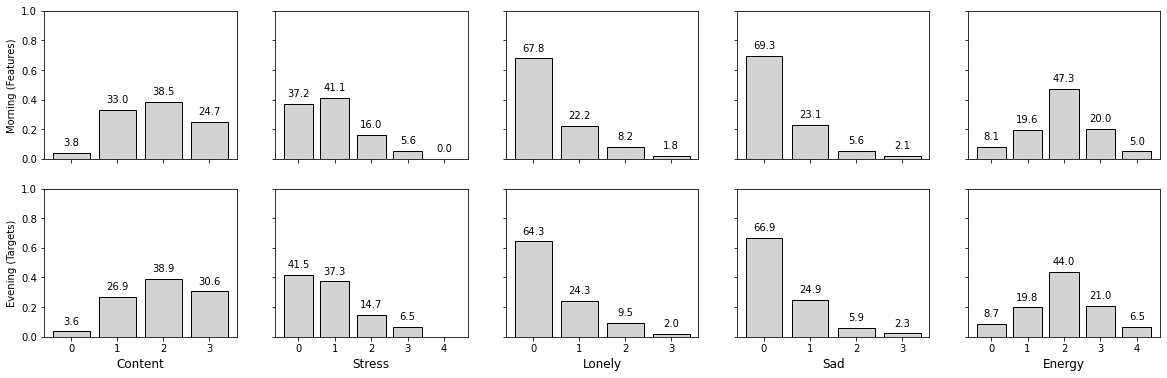

In [85]:
_  = get_mood_distribution(data,plot=True)

## Difference in Scores (Evening - Morning)
The simplest way to understand the difference in mood scores is to simply subtract them from one another. The more identical the scores, the greater the instance of zero.

### Aggregate
Just looking at the responses from everyone.

In [4]:
def get_mood_difference(df_in,moods=["content","stress","lonely","sad","energy"],plot=False):
    """
    Calculates the score difference between mood scores ofthe same name.
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    plot : boolean
        whether or not to output the histograms of the differences for each
        mood
        
    Returns
    -------
    df : DataFrame
        Original dataset with the mood scores removed and replaced with the 
        differences
    """
    df = df_in.copy()
    for mood in moods:
        df[f"{mood}_diff"] = pd.to_numeric(df[f"{mood}_e"]) - pd.to_numeric(df[f"{mood}_m"])
        
    df.drop([col for col in df.columns if col[-2:] in ["_e","_m"]],axis="columns",inplace=True)
    
    if plot:
        _, axes = plt.subplots(1,len(moods),figsize=(len(moods)*5,3),sharey=True)
        for i, (mood, ax) in enumerate(zip(moods,axes)):
            temp = pd.DataFrame(data=df[f"{mood}_diff"].value_counts())
            temp["percent"] = temp[f"{mood}_diff"] / temp[f"{mood}_diff"].sum()
            temp.sort_index(ascending=False,inplace=True)
            rects = ax.bar(temp.index,temp["percent"],edgecolor="black",color="lightgray")
            # x-axis
            if i == 4:
                ax.set_xlim([-4.5,4.5])
                ax.set_xticks(np.arange(-4,5,1))
            else:
                ax.set_xlim([-3.5,3.5])
                ax.set_xticks(np.arange(-3,4,1))
            if i == 2:
                ax.set_xlabel("Score Difference (E - M)",fontsize=14)
            # y-axis
            ax.set_ylim([0,1])
            # remainder
            ax.set_title(mood.title() + f" (n={len(df)})")
            for score, height in zip(temp.index,temp["percent"]):
                ax.text(score,height+0.05,round(height*100,1),ha="center")
            
            
        axes[0].set_ylabel("Percent")
        plt.show()
        plt.close()
        
    return df

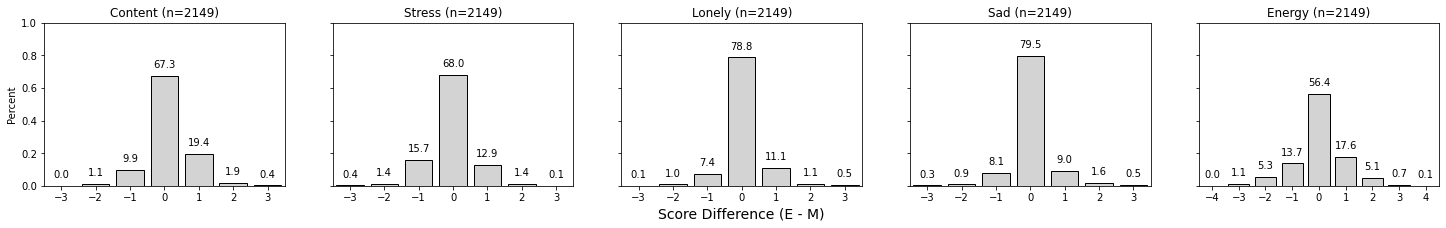

In [5]:
mood_diff = get_mood_difference(data,plot=True)

<div class="alert alert-block alert-info">
    
As expected, many of the differences between the mood scores are zero. This finding is less apparent when considering `energy` which makes sense since the energy of the participants should change. However, I would expect this change to be skewed towards a positive difference (indicating participants were _more_ tired in the evening) but that is not the case. Although they could have low energy in the mornings when they initially wake up. 
    
</div>

<div class="alert alert-block alert-info">
    
The maximum percentages also highlight a sort of upper bound on the accuracy of the model. Just like with our previous analysis, the model might be biased to simply report the same mood score since that is the most influential factor it seems.
    
</div>

### Individual Basis
Participants with a low number of responses might be skewing the data

#### Responses
Before looking at the distributions from each participants' responses, we should actually see how many repsonses they submitted.

In [6]:
def get_response_n(df_in,moods=["content","stress","lonely","sad","energy"],timing="e",plot=False):
    """
    Gets the number of responses from each individual for each provided mood
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    timing : {"e","m"}, default "e"
        specifies whether to consider evening ("e") or morning ("m") EMAs
    plot : boolean
        whether or not to output the histograms of the differences for each
        mood
        
    Returns
    -------
    responses : DataFrame
        DataFrame indexed by participant with columns corresponding to the number
        of responses for the provided moods
    """
    df = df_in.copy()
    responses = {key: [] for key in ["beiwe"] + moods}
    for pt in df["beiwe"].unique():
        responses["beiwe"].append(pt)
        df_pt = df[df["beiwe"] == pt]
        for mood in moods:
            responses[mood].append(len(df_pt[f"{mood}_{timing}"].dropna()))
            
    responses = pd.DataFrame(data=responses)
    if plot:
        _, axes = plt.subplots(len(moods),1,figsize=(22,len(moods)*3),sharex=True,gridspec_kw={"hspace":0.1})
        for mood, ax in zip(moods, axes):
            responses.sort_values(mood,inplace=True)
            ax.scatter(responses["beiwe"],responses[mood],color="black")
            ax.set_title(mood,fontsize=16,pad=0)
            ax.set_ylim([0,70])
            for loc in ["top","right"]:
                ax.spines[loc].set_visible(False)
            
        ax.set_xticklabels(responses["beiwe"].unique(),rotation=-30,ha="left")
        plt.show()
        plt.close()
        
    return responses

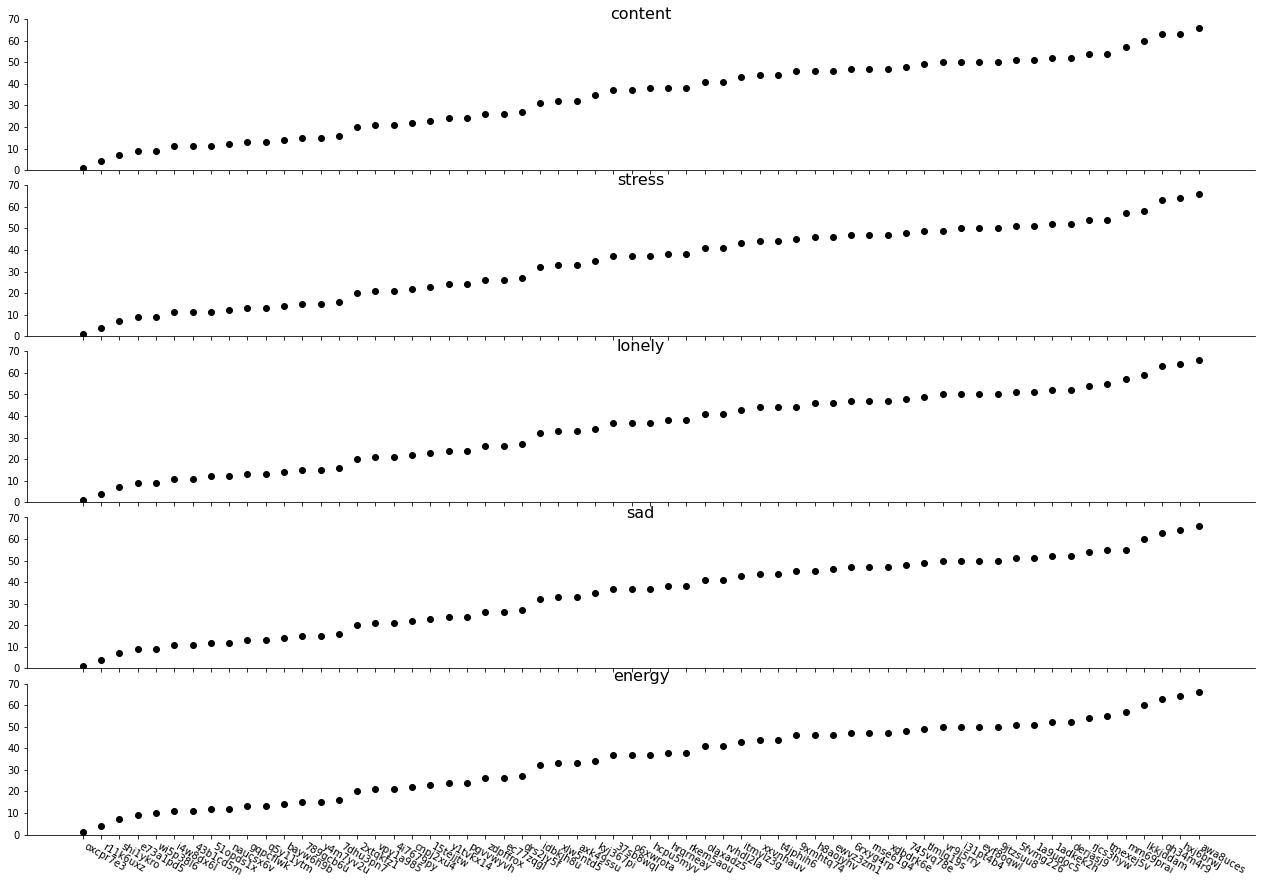

In [7]:
responses_e = get_response_n(data,plot=True)

### Inspecting Responses
Now that we know the number of responses, we can see the distribution of how participants rated their moods.

oxcpr7e3


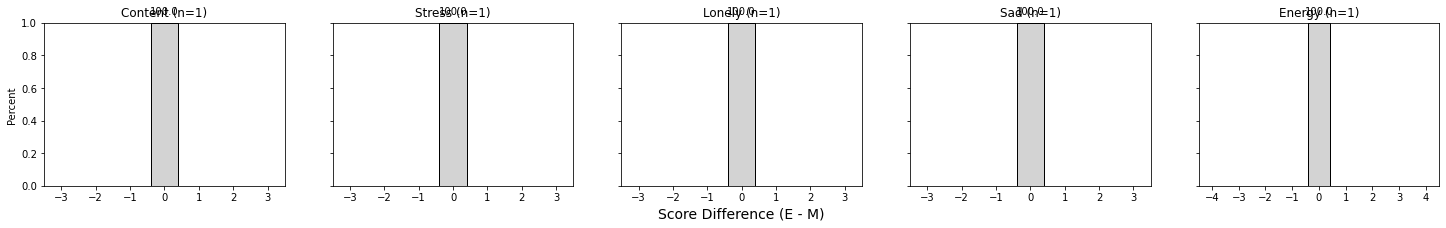

r11k6uxz


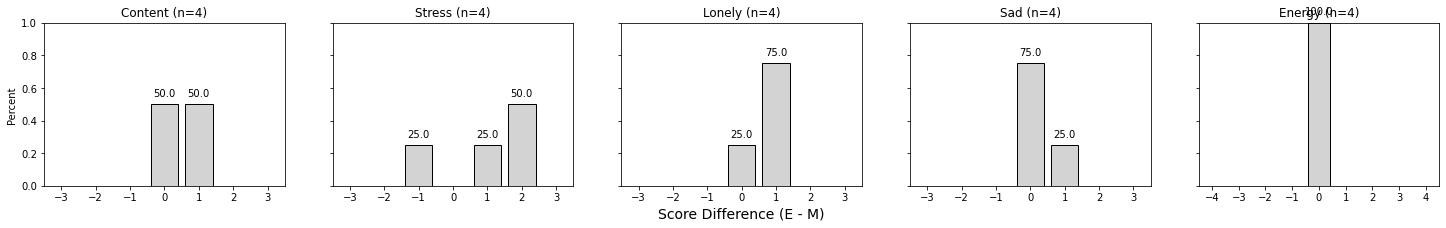

shi1ykro


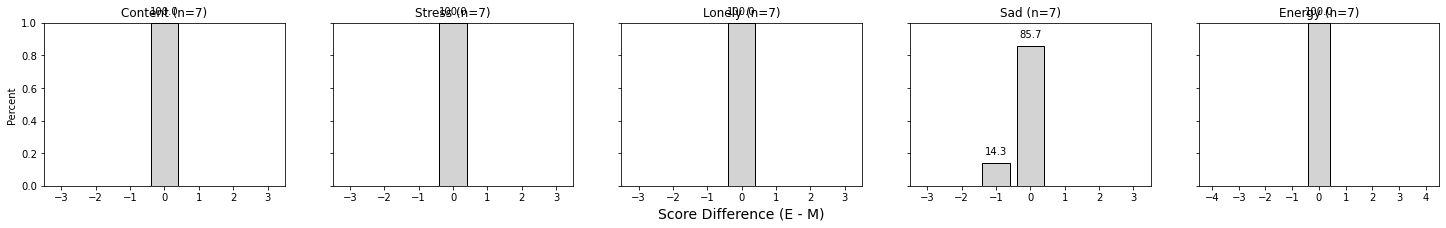

e73a1pd5


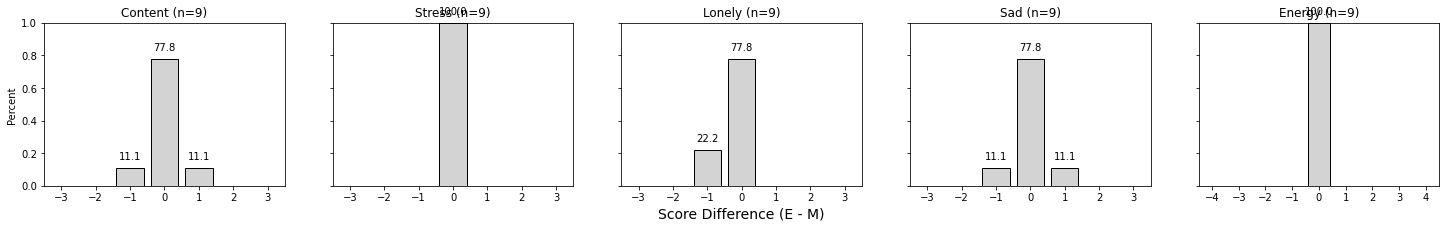

wi5p38l6


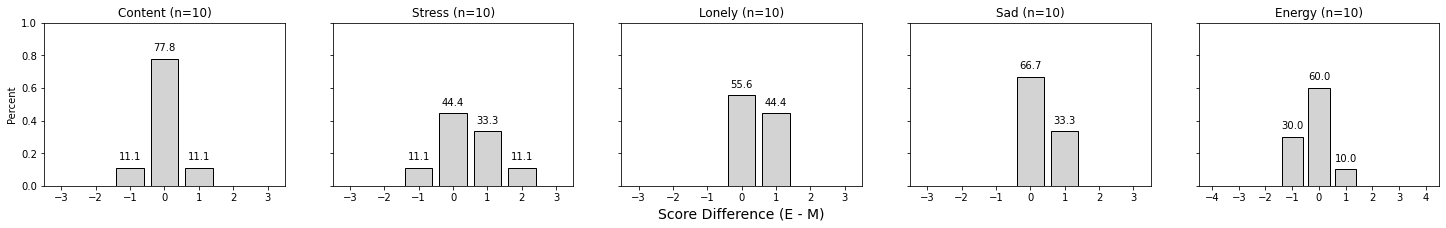

43b1cd5m


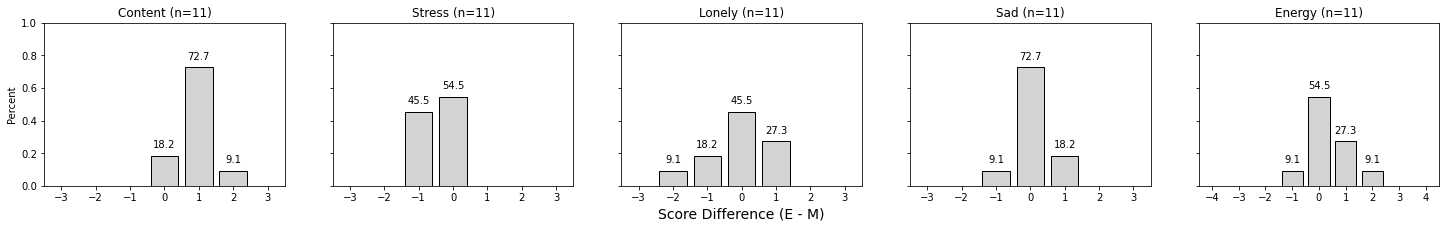

i4w8dx6l


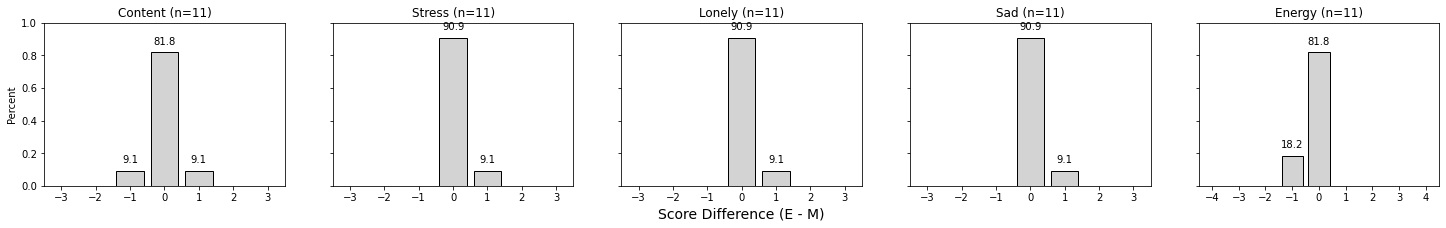

51opds1x


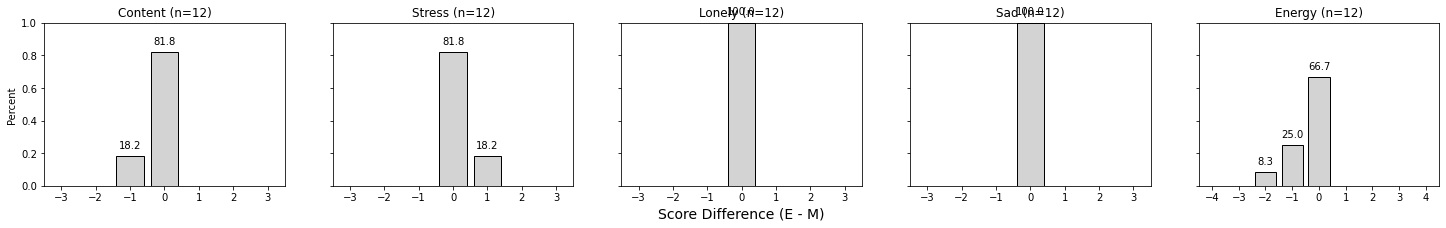

naucsx6v


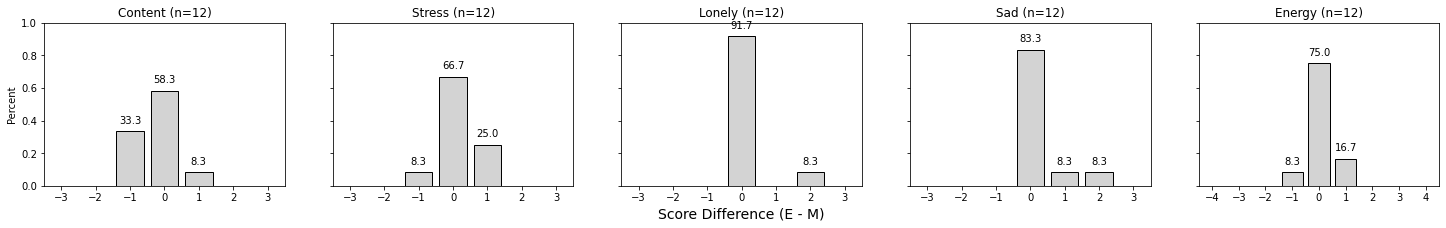

gqpcflwk


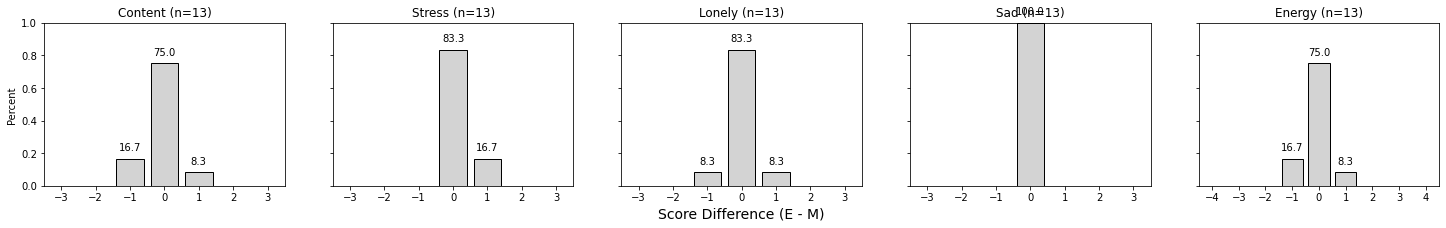

q5y11ytm


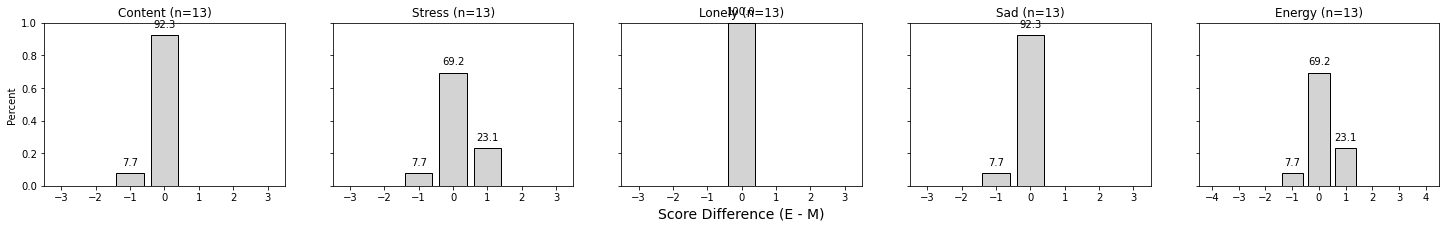

bayw6h9b


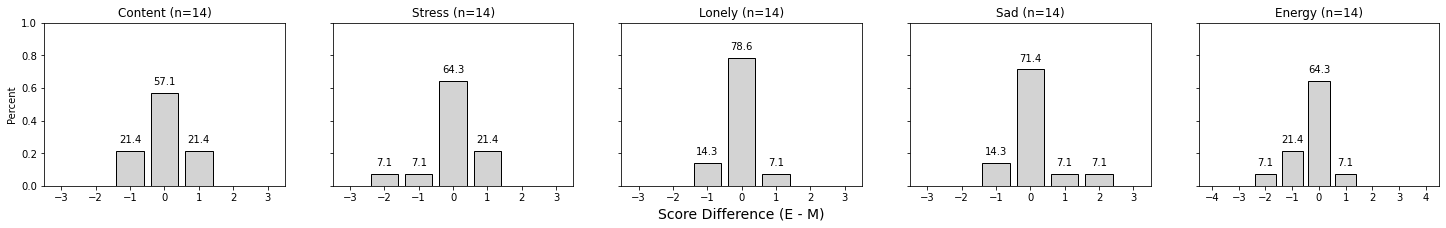

y4m7yv2u


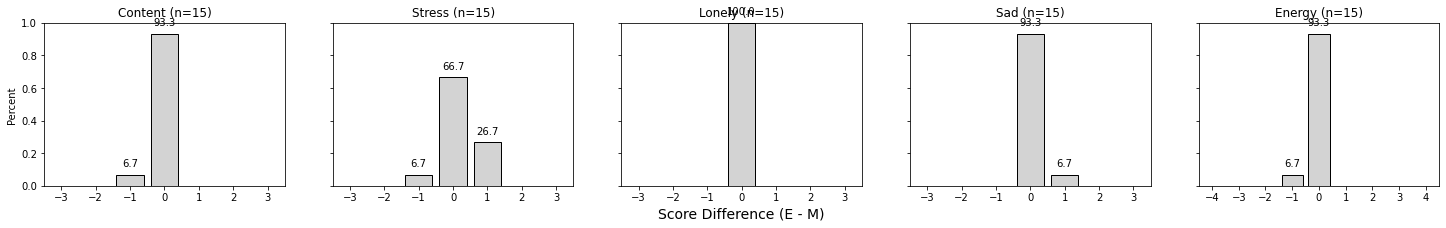

789gcb6u


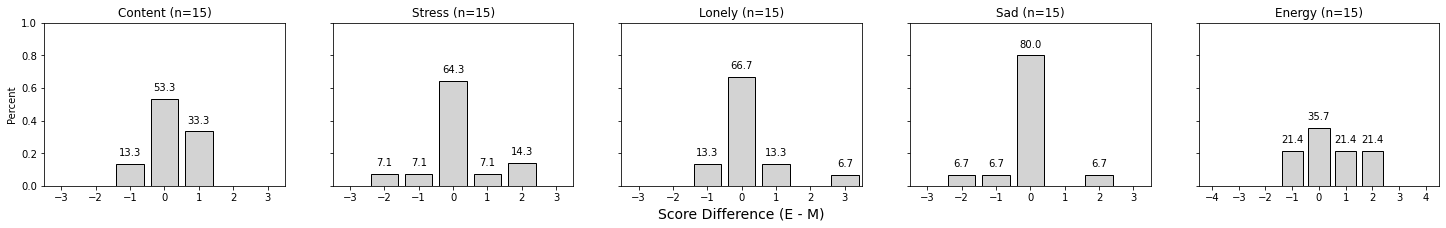

7dhu3pn7


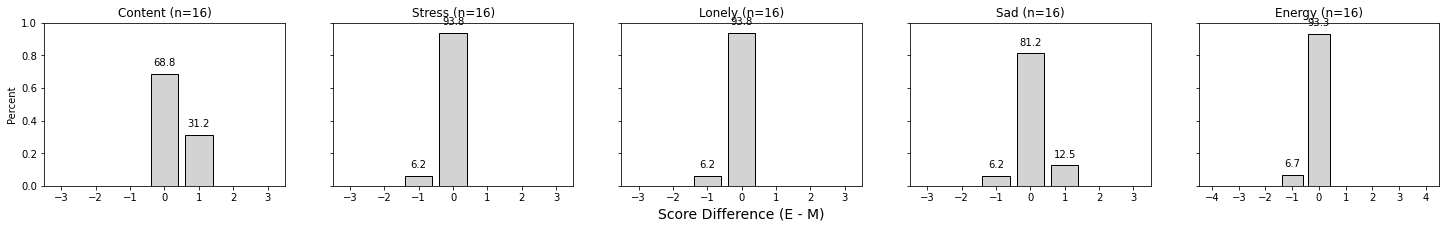

2xtqkfz1


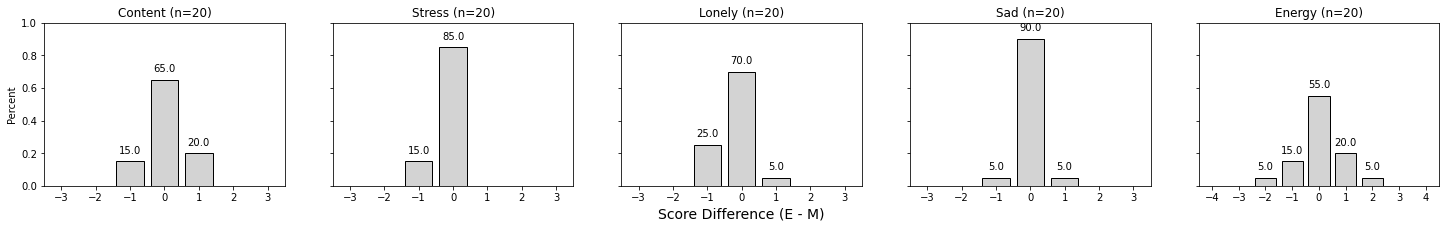

4i7679py


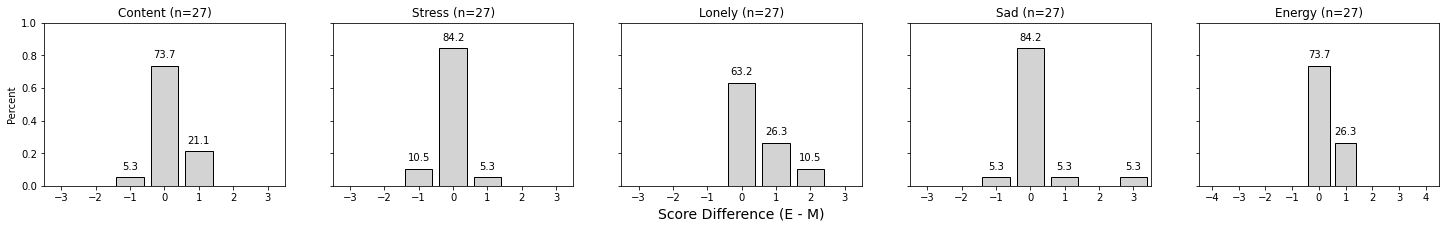

vpy1a985


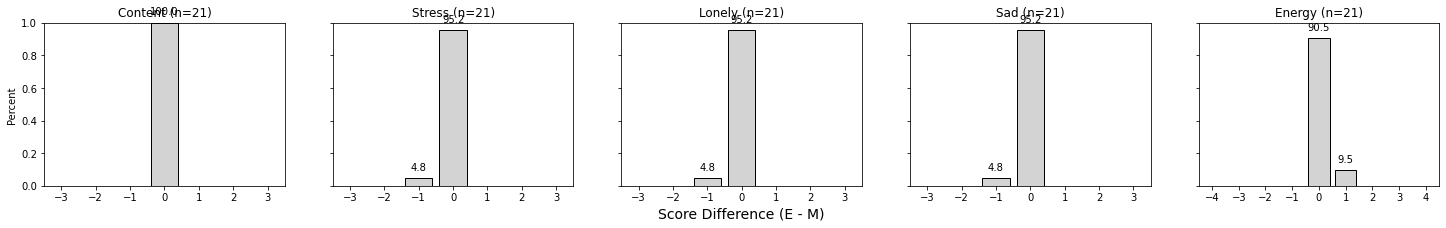

cnpj2xu4


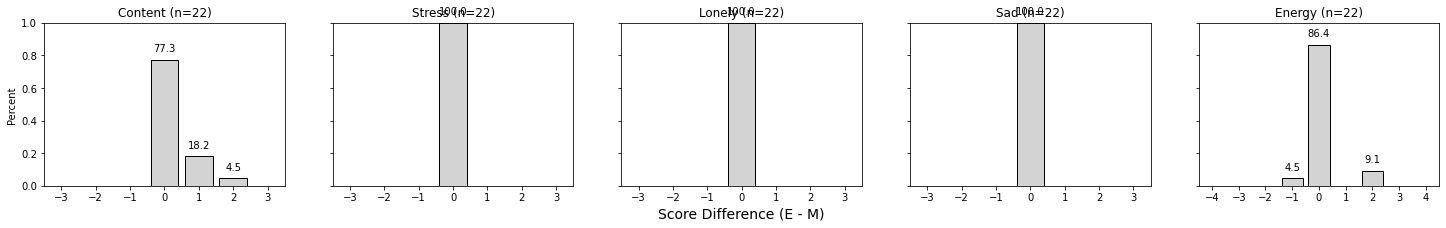

15tejjtw


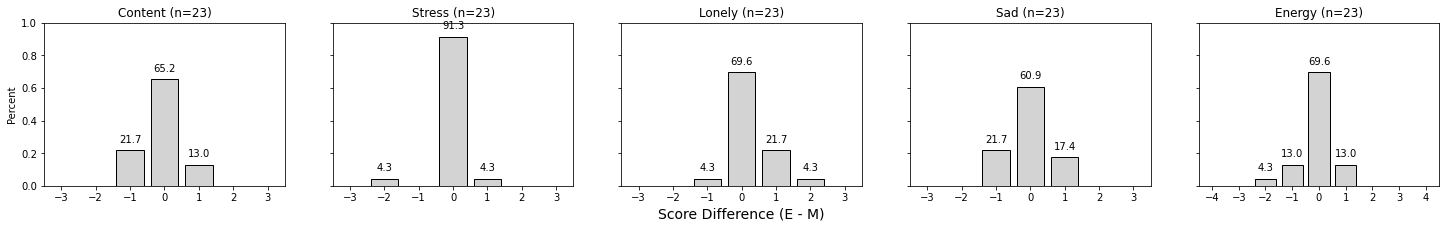

y1tvkx14


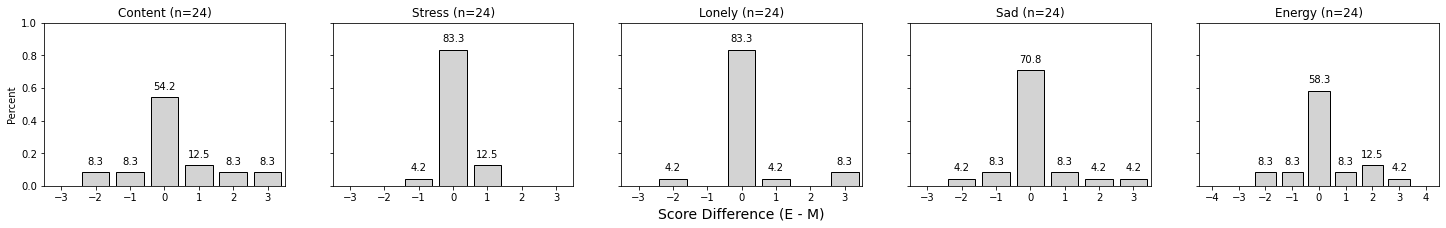

pgvvwyvh


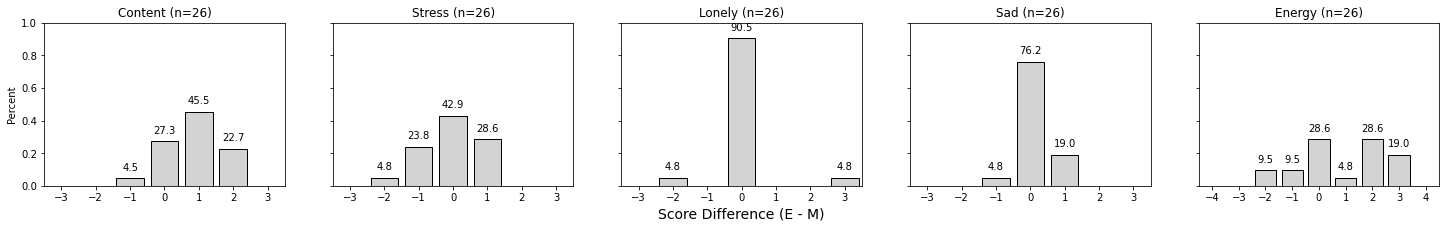

zdpffrox


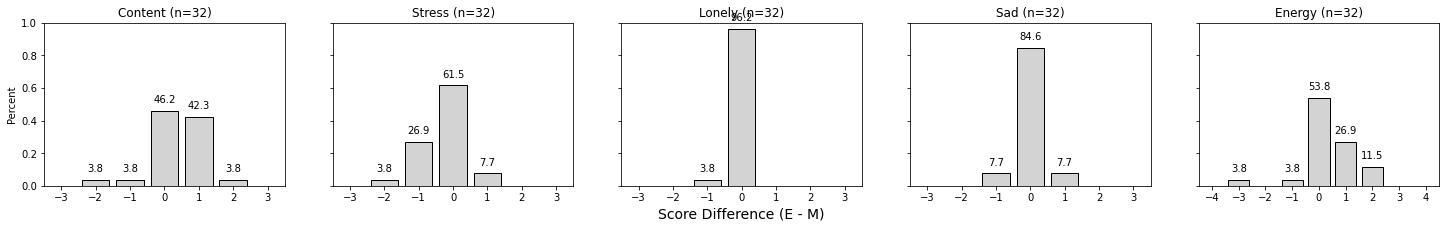

ec77zqgl


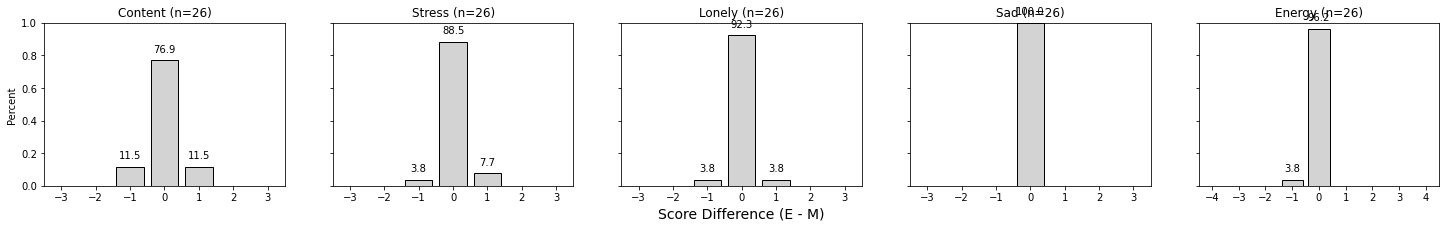

drs2jy5f


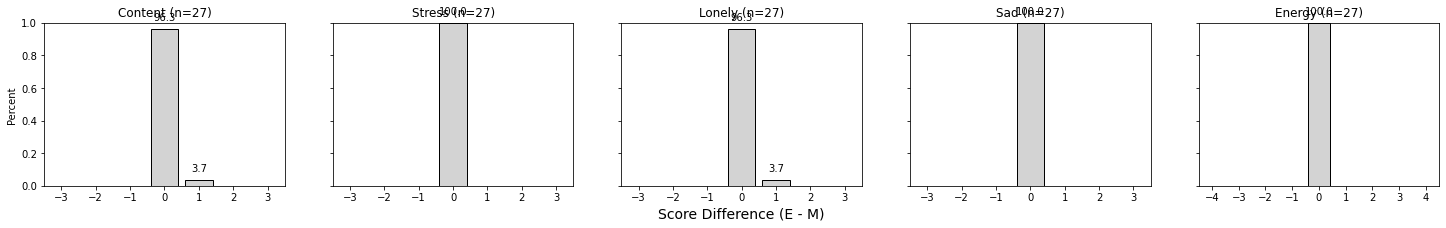

idbkjh8u


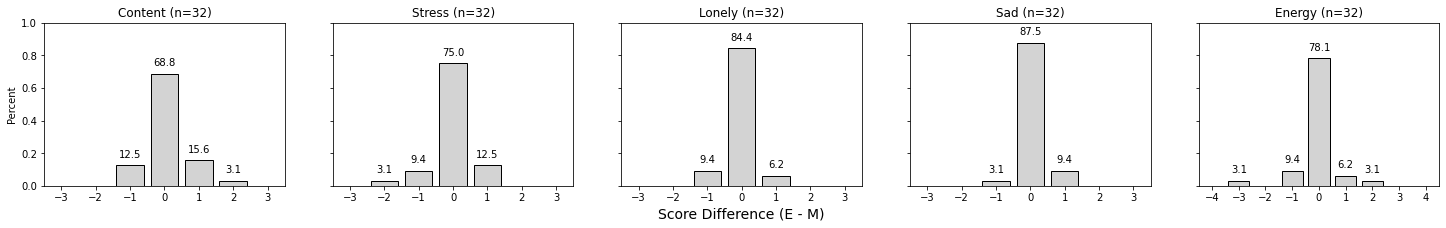

xlw5ntd5


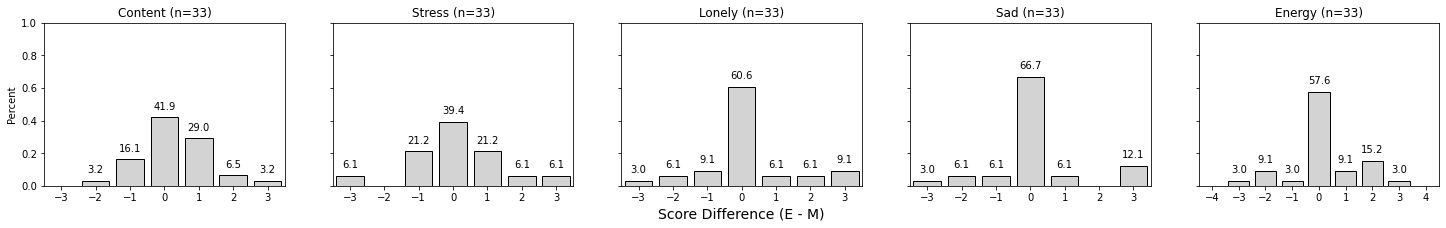

axk49ssu


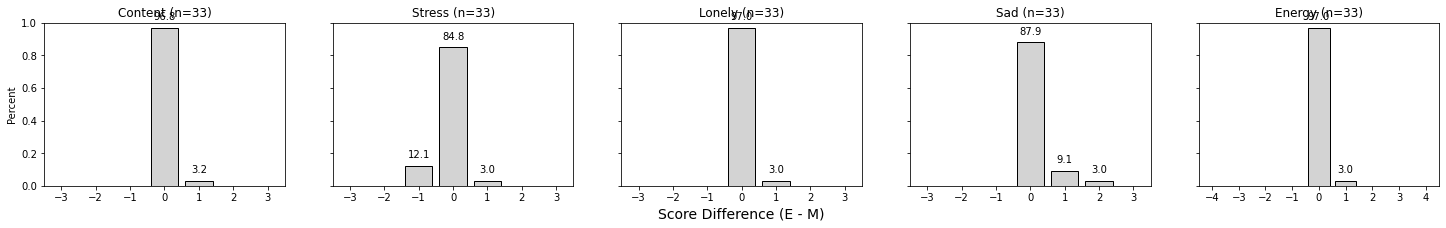

kyj367pi


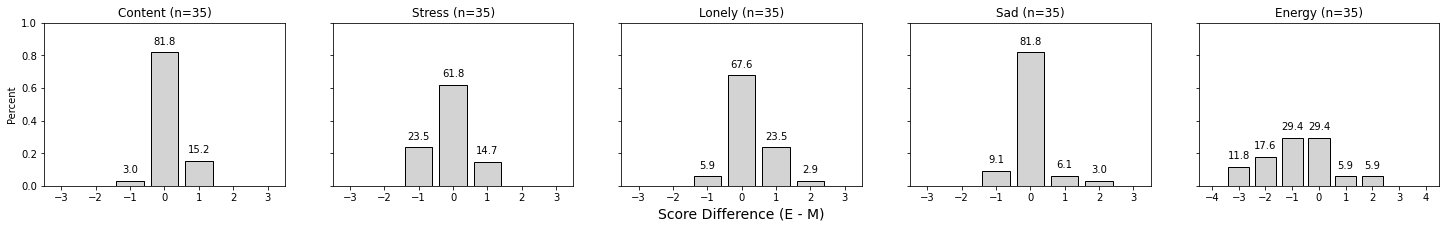

37sb8wql


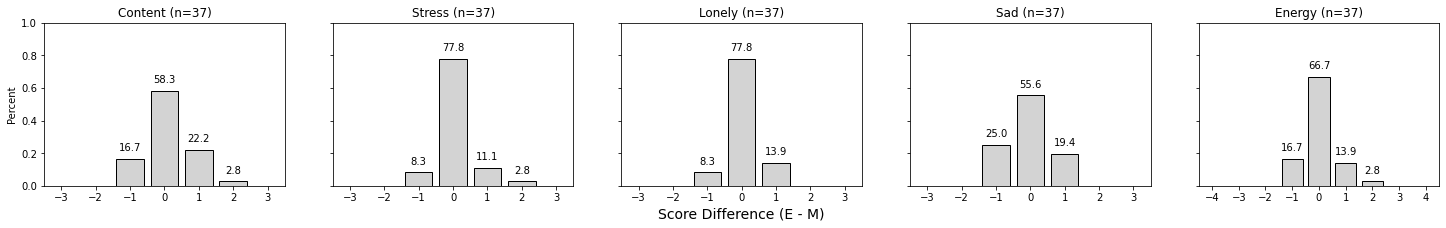

o6xwrota


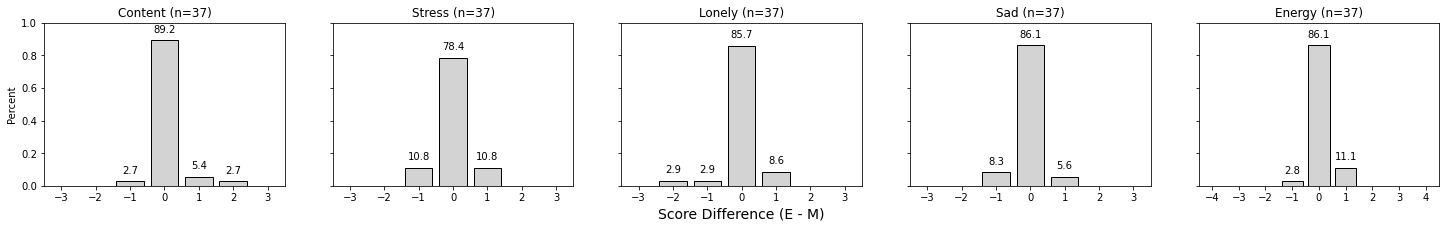

hcpu5myv


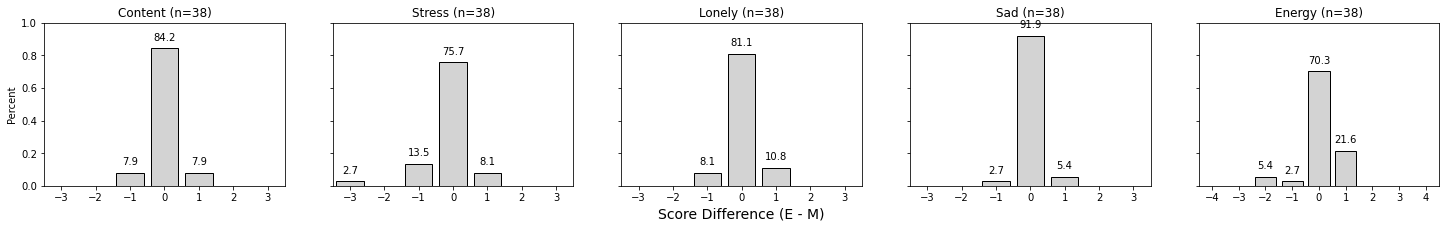

hrqrneay


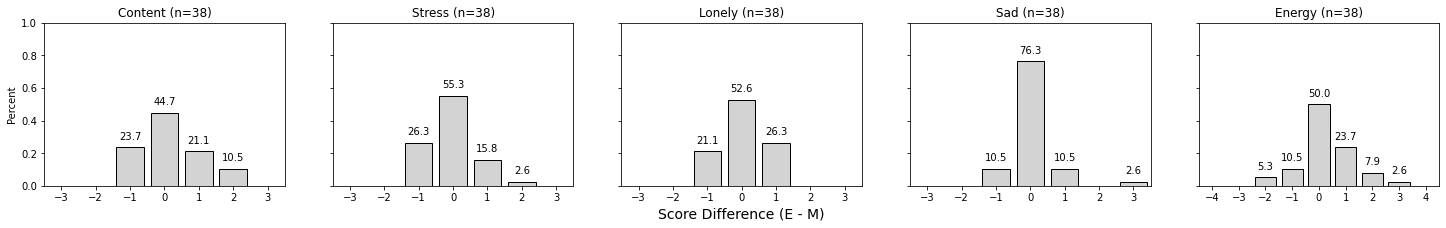

rkem5aou


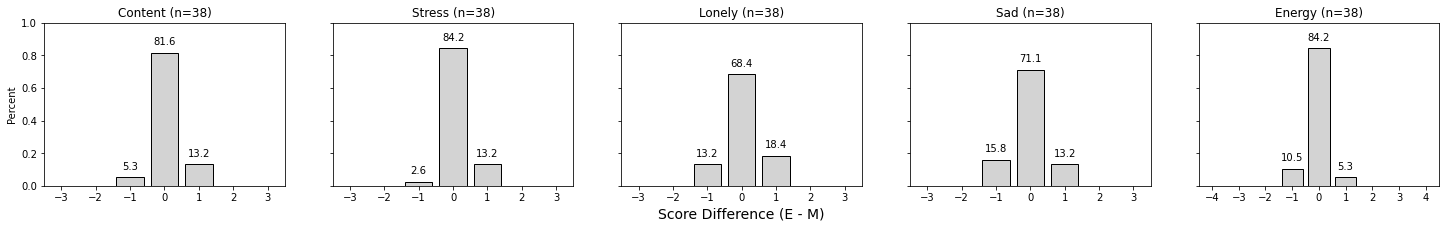

rvhdl2la


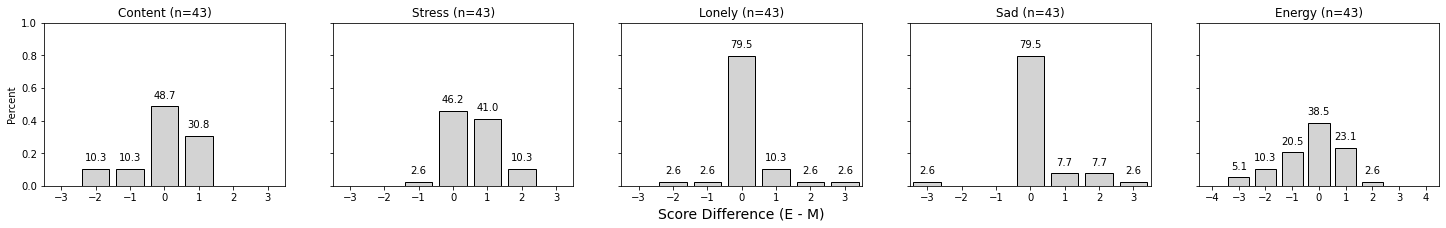

olaxadz5


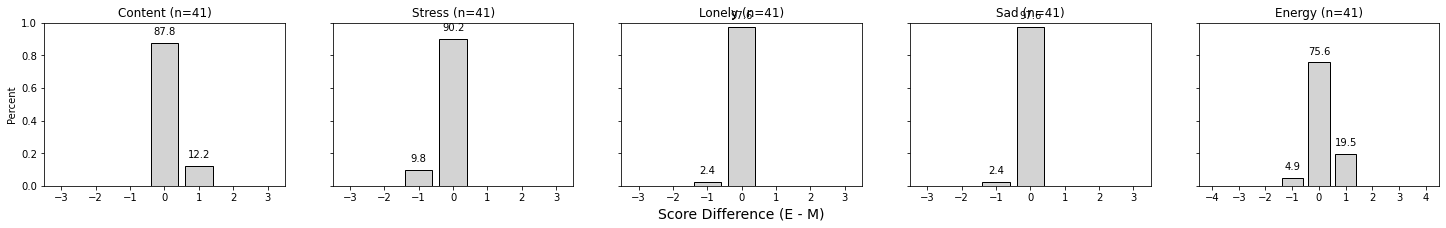

itmylz3g


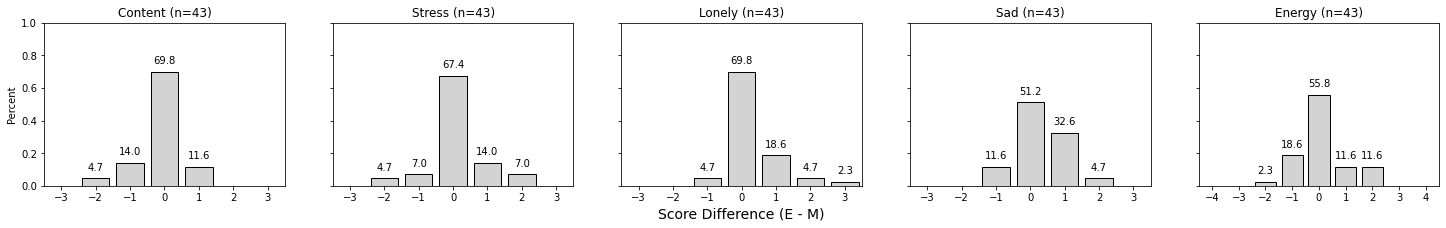

t4jphih6


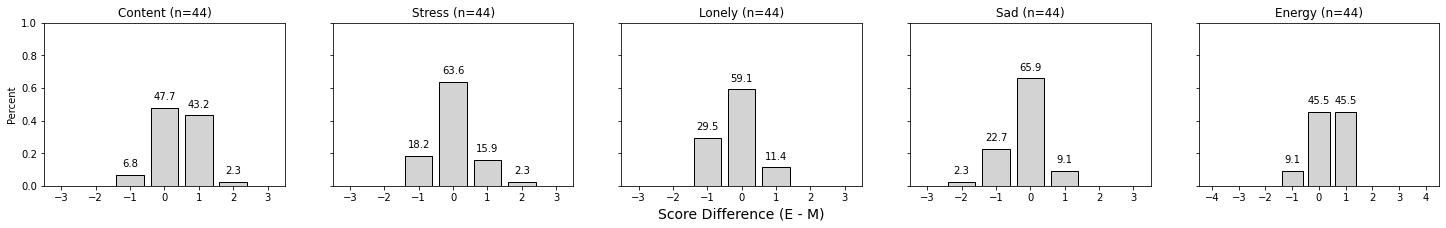

xxvnhauv


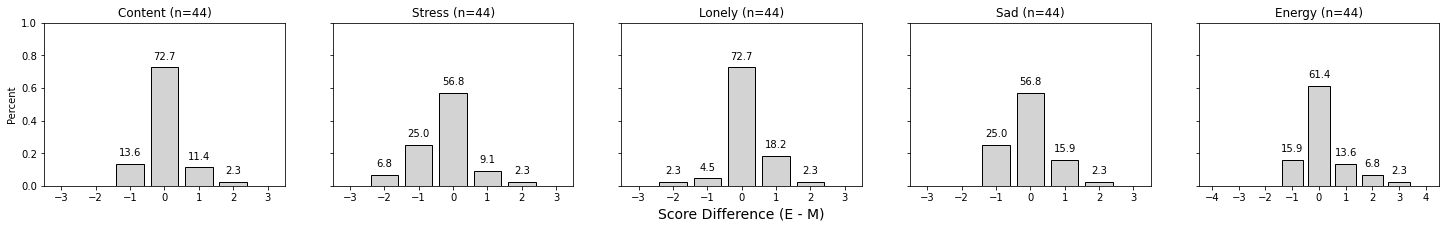

9xmhtq74


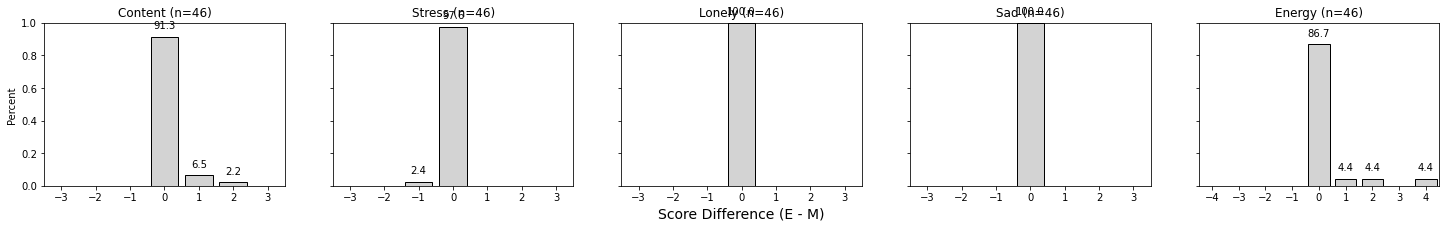

h8aoiyhv


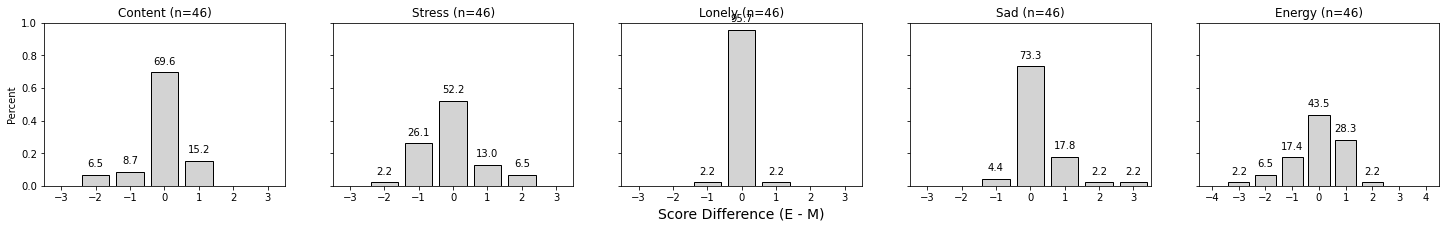

ewvz3zm1


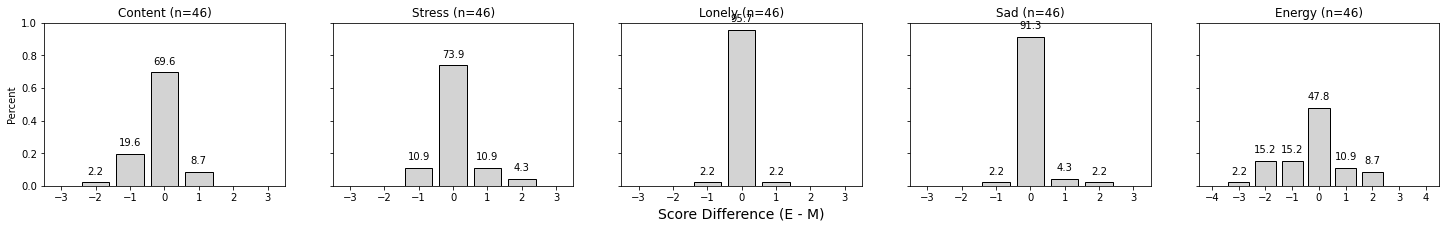

6rxyg4rp


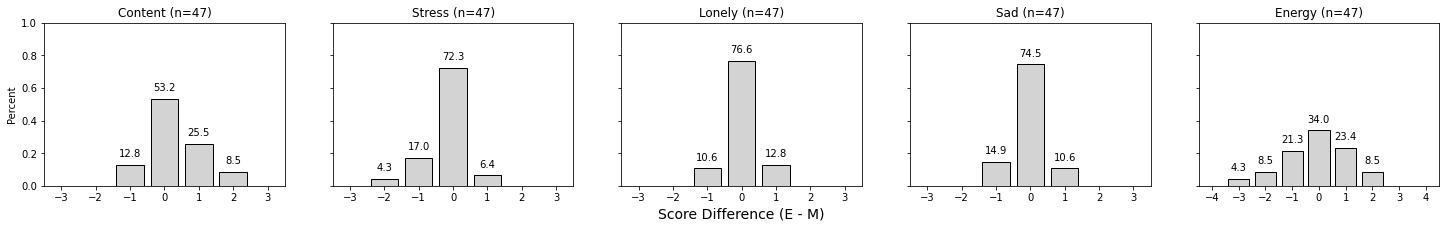

rnse61g4


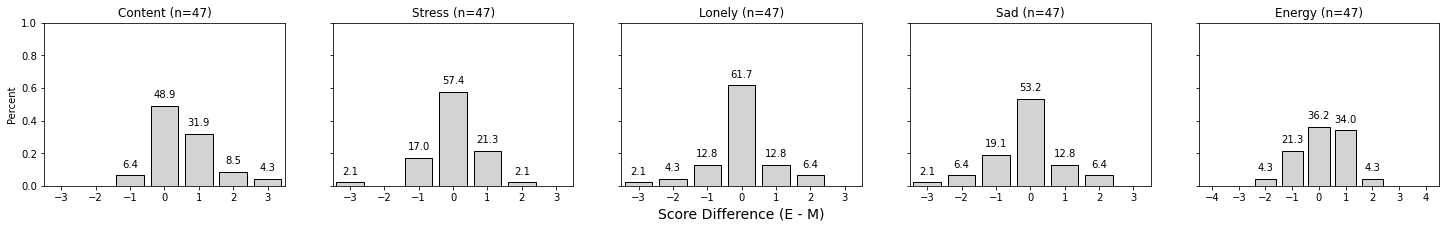

xdbdrk6e


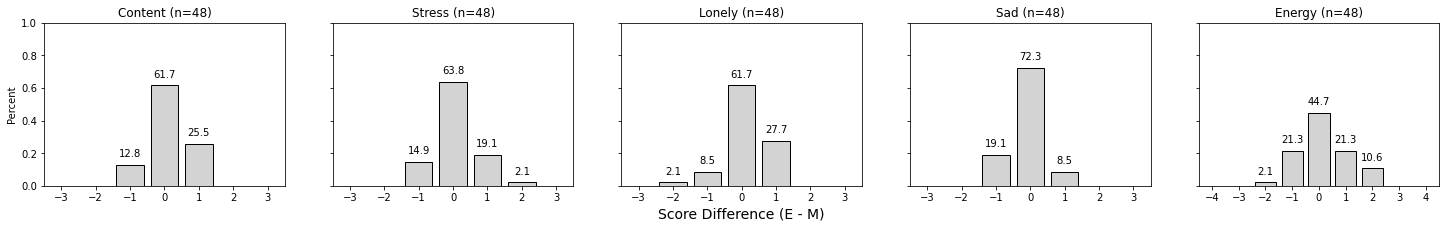

745vq78e


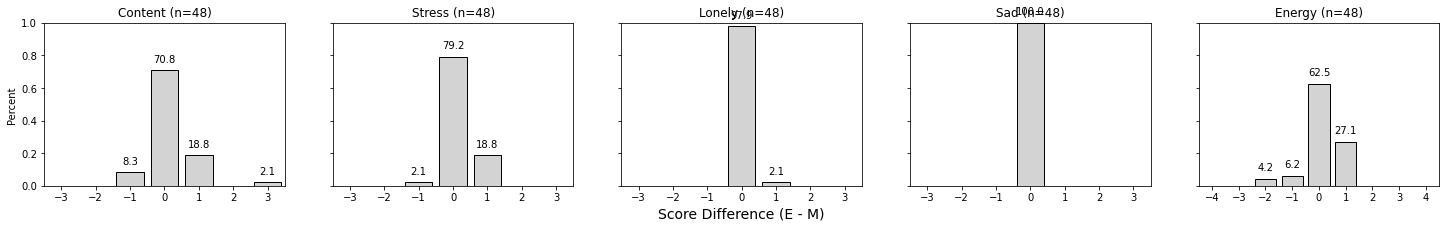

tlmlq19s


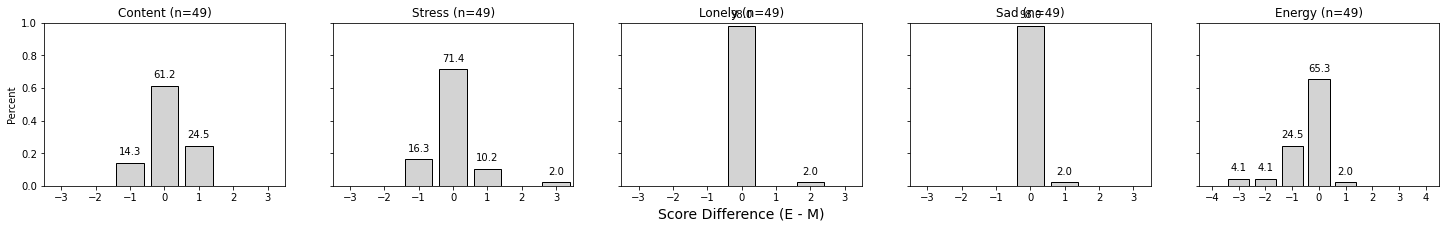

eyf8oqwl


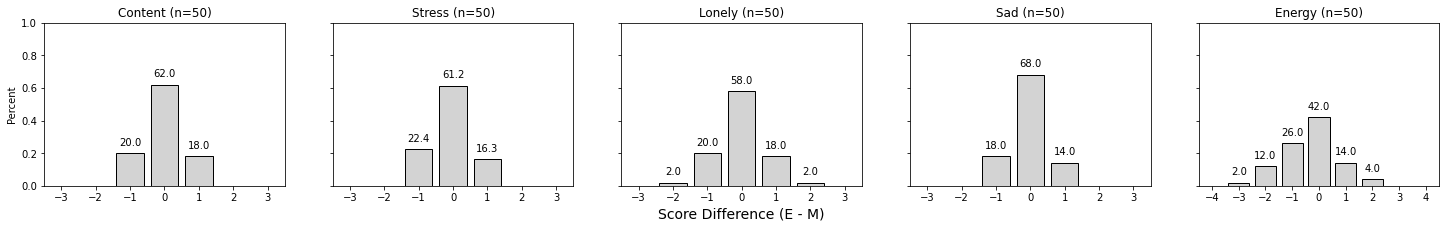

9jtzsuu8


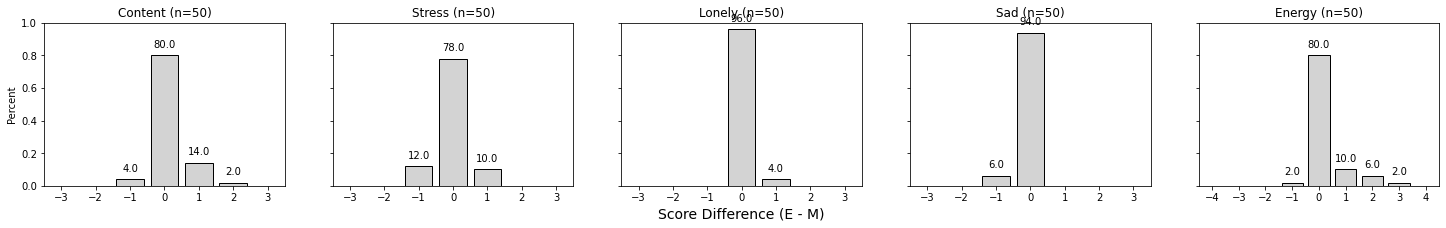

i31pt4b4


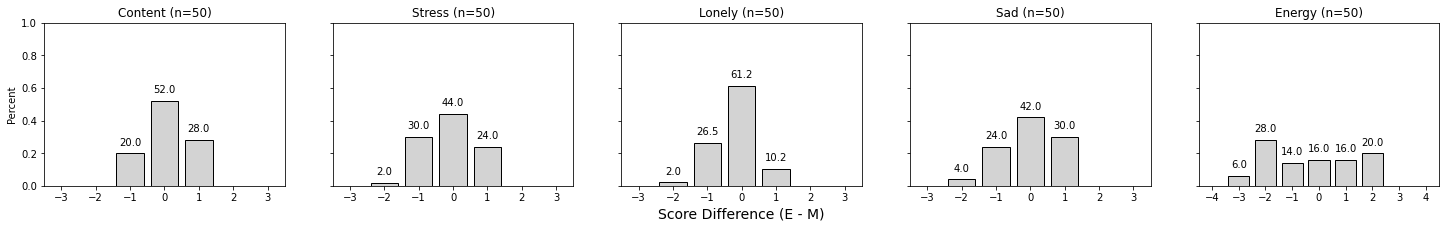

vr9j5rry


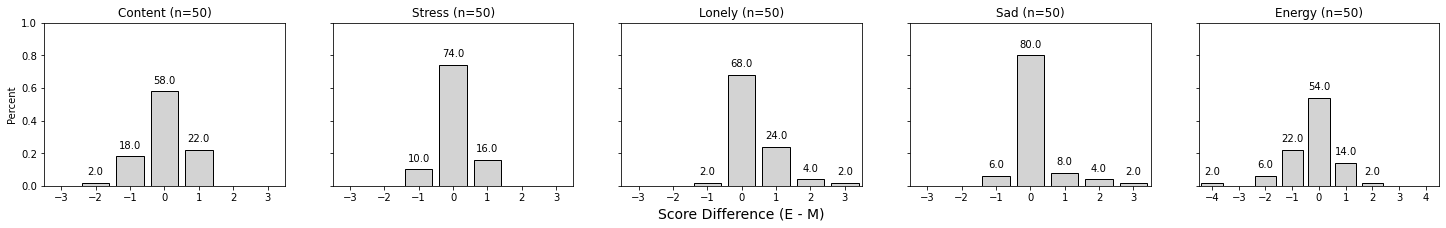

5fvmg226


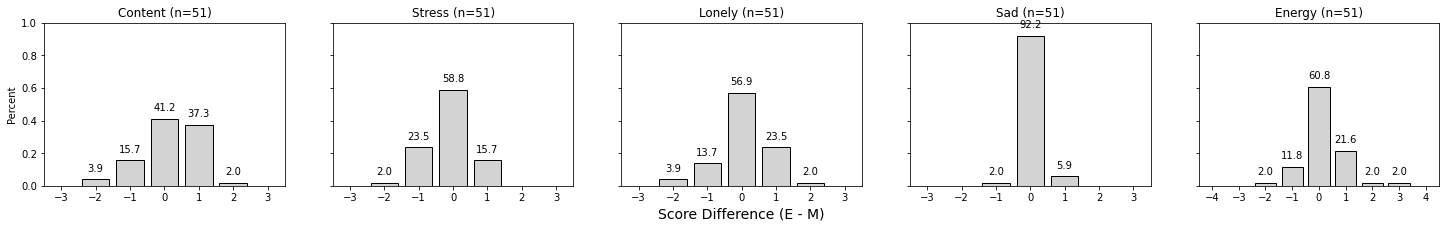

1a9udoc5


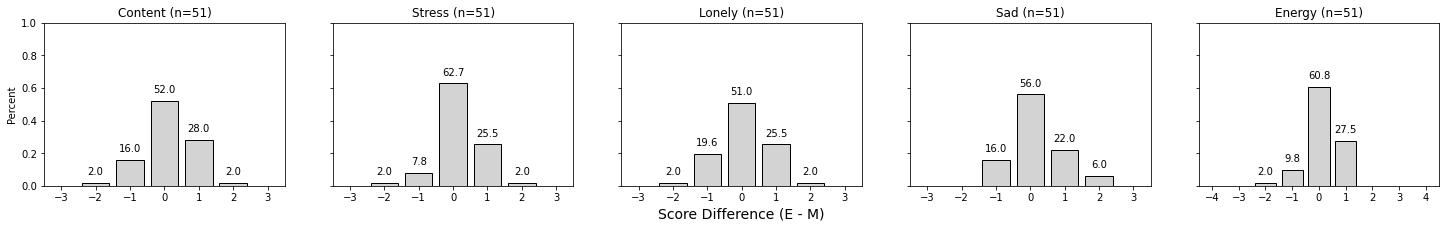

1adkek2h


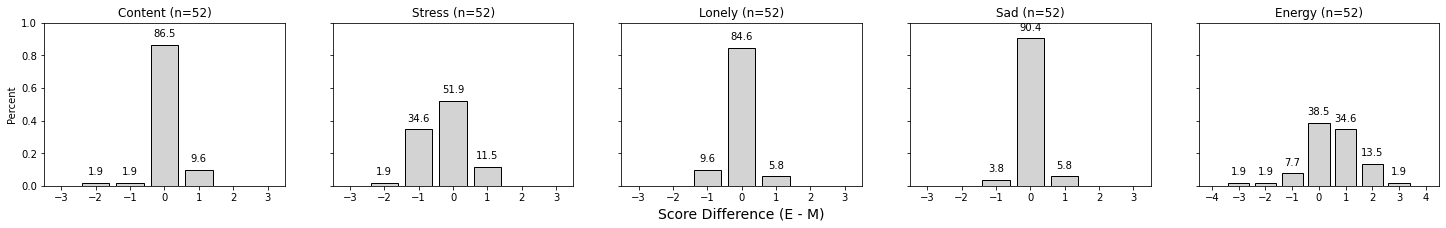

derjasj9


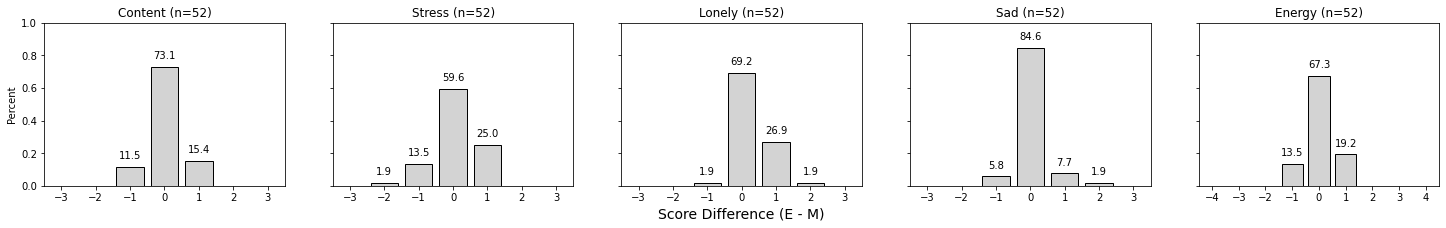

rjcs3hyw


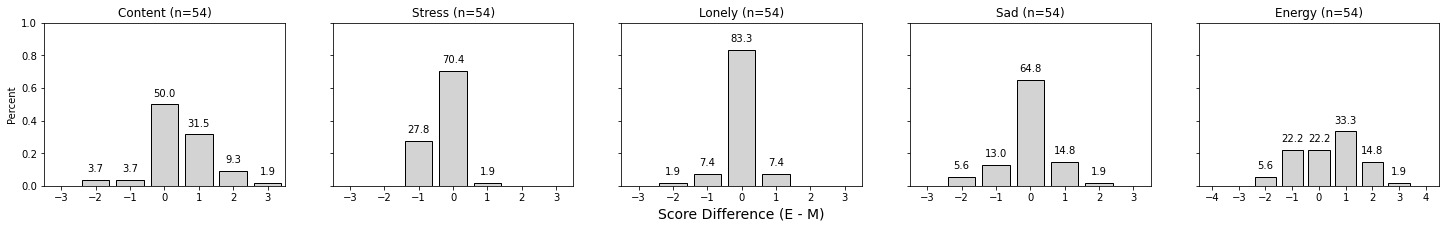

tmexej5v


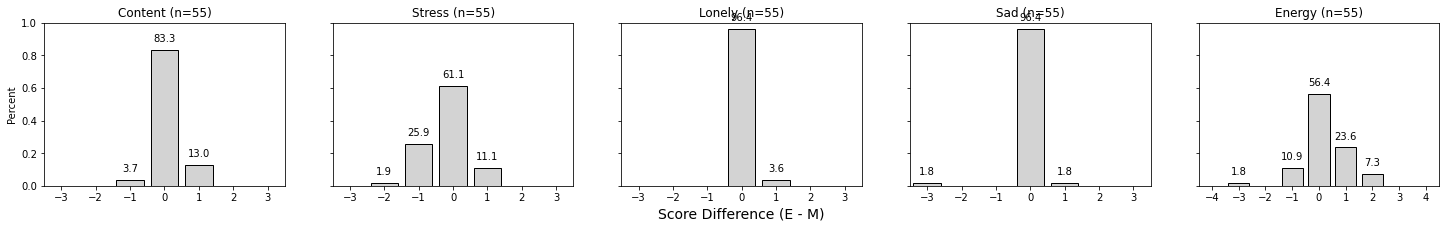

mm69prai


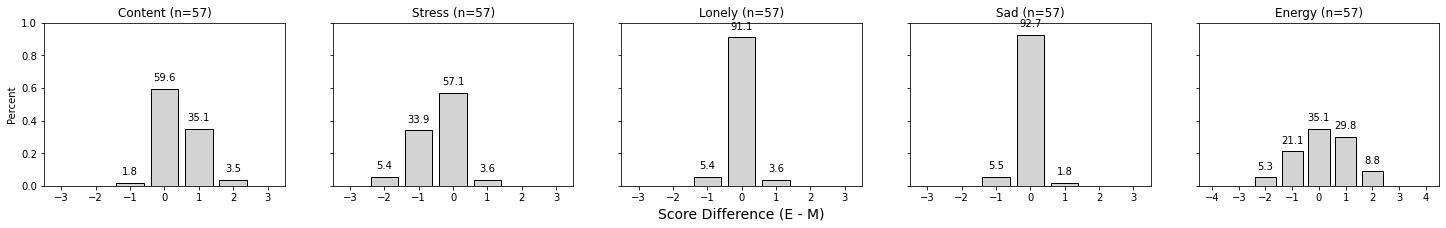

lkkjddam


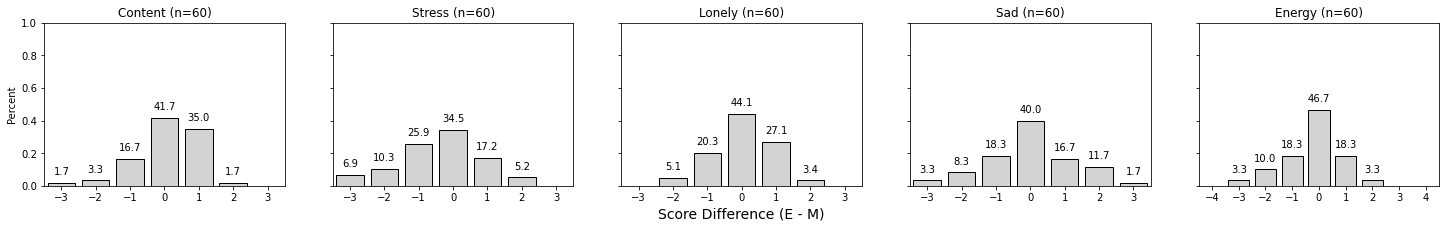

qh34m4r9


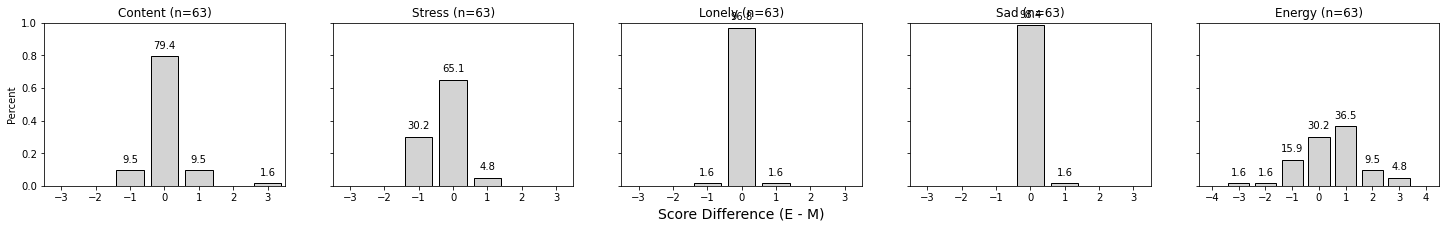

hxj6brwj


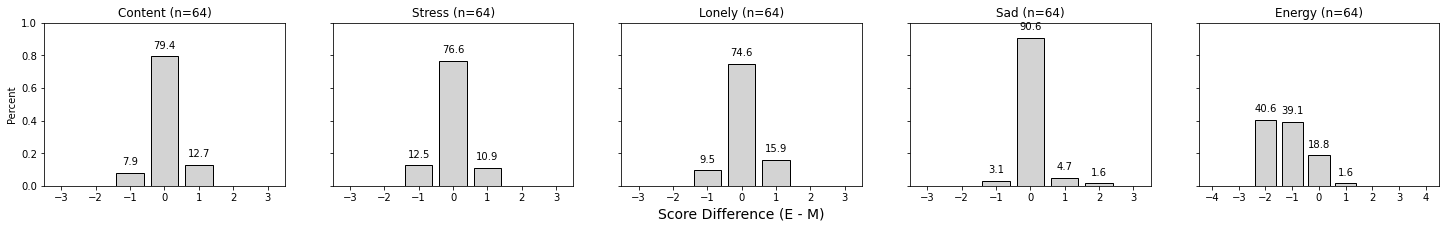

awa8uces


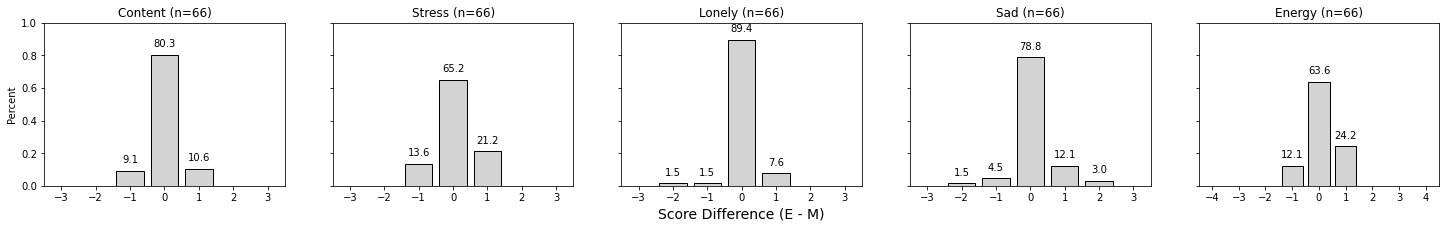

In [8]:
data_with_responses = data.merge(responses_e,on="beiwe")
data_with_responses["n"] = data_with_responses[["content","stress","lonely","sad","energy"]].mean(axis=1)
data_with_responses.sort_values("n",inplace=True)
for pt in data_with_responses["beiwe"].unique():
    print(pt)
    _ = get_mood_difference(data_with_responses[data_with_responses["beiwe"] == pt],plot=True)

<div class="alert alert-block alert-info">
    
Despite the varying levels of responses, I don't feel that the participants with only a few responses really responded _significantly_ different than those that responded more often. 
    
We should remove the participant with only one response though...
    
</div>

In [9]:
data = data[data["beiwe"] != "oxcpr7e3"]

---

<a id='classification'></a>

# Classification

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Bernoulli Naive Bayes
from sklearn.naive_bayes import GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
# Support Vector
from sklearn.svm import SVC
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
# Logistic Regressions
from sklearn.linear_model import LogisticRegression

## Selecting Feature Values and Targets

In [ ]:
def get_x_and_y(df_in,mood="content"):
    """
    Gets the feature and target datasets corresponding to the target
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    mood : {"content","stress","lonely","sad","energy"}, default "content"
        Mood to consider - must be a column in df_in
        
    Returns
    -------
    X : array of floats
        Morning EMA mood reports
    y : list of floats
        Evening EMA mood reports corresponding to the input mood
    groups : Series of strings
        the participants that the X and y vectors are associated with
    """
    df = df_in.copy()
    # removing NaN
    df.dropna(subset=[f"{mood}_e"],axis="rows",inplace=True)
    df.dropna(subset=[col for col in data.columns if col.endswith("_m") and col[:4] != "time"],axis="rows",inplace=True)
    # getting features and targets
    X = df[[col for col in data.columns if col.endswith("_m") and col[:4] != "time"]].values
    y = df[f"{mood}_e"].values
    # getting groups
    groups = df["beiwe"]
    return X, y, groups

## Option to Binarize
In addition to multiclass prediction, we want to have the option to predict binary targets.

The binary classification should not necessarily be based on low (0 and 1) and high (2 and 3) scores, but rather by taking a closer look at the available data. For instance, since the lonely and sadness scores are so heavily skewed towards  "Not at all" we should consider 1, 2, and 3 as "high" scores since they are uncommon. Or rather we can look at it as "not lonely" and "lonely" which is true even if the response is not strong. 

In [80]:
def binarize(df_in,moods=["content","stress","lonely","sad","energy"]):
    """
    Binarizes the features and targets
    
    Parameters
    ----------
    df_in : DataFrame
        Original data with columns corresponding to the provided moods
    moods : list-like, default ["content","stress","lonely","sad","energy"]
        Strings of the moods to consider - must be columns in df_in
    
    Returns
    -------
    df : DataFrame
        original dataframe with mood scores replace with binary values
    """
    df = df_in.copy()
    for mood in moods:
        for timing in ["m","e"]:
            if mood in ["content","energy"]:
                df[f"{mood}_{timing}"] = [0 if score < 2 else 1 for score in df[f"{mood}_{timing}"]]
            else:
                df[f"{mood}_{timing}"] = [0 if score == 0 else 1 for score in df[f"{mood}_{timing}"]]
    
    return df

In [81]:
data_bi = binarize(data)

## Comparing and Tuning Models
We test a slew of classification schemes to get the best model

### Defining Models and Hyperparameters to Tune
We use some common classifiers to predict the mood scores that should work for multi-class and binary outcomes.

In [12]:
model_params = {
    "random_forest": {
        "model":RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "naive_bayes": {
        "model":GaussianNB(),
        "params": {
            
        }
    },
    "k-nearest_neighbor": {
        "model":KNeighborsClassifier(),
        "params": {
            "n_neighbors":[3,5,7],
            "weights":["uniform","distance"],
            "metric":["euclidean","manhattan","minkowski","jaccard","matching"],
            "p":[1,2],
        }
    },
    "svc": {
        "model": SVC(),
        "params": {
            "kernel":["linear","poly","sigmoid","rbf"],
        }
    },
    "gradientboost":{
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators":[10,50,100],
            "max_depth":[1,2,3,4,5],
            "min_samples_split":[2,4],
            "min_samples_leaf":[1,2],
        }
    },
    "logistic_regression": {
        "model":LogisticRegression(random_state=42,max_iter=500),
        "params": {
            "fit_intercept":[True,False],
            "solver":["lbfgs","liblinear"],
        }
    },
}

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

In [86]:
def optimize_models(df,params,moods=["content","stress","lonely","sad","energy"]):
    """
    Runs GridSearch to determine the best hyperparameters for the given models
    
    Parameters
    ----------
    df : DataFrame
        data with columns for each mood
    params : dict
        ML models and the parameters that we wish to tune
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    
    Returns
    -------
    <results> : DataFrame
        
    """
    scores = []
    for mood in moods:
        for model_name, mp in params.items():
            s = datetime.now()
            print(f"\t{model_name.replace('_',' ').title()}")
            clf = GridSearchCV(mp["model"],mp["params"],cv=5,return_train_score=False)
            X, y, _ = get_x_and_y(df,mood=mood)
            clf.fit(X, y)
            scores.append({
                "mood":mood,
                "model":model_name,
                "best_score":clf.best_score_*100,
                "best_params":clf.best_params_
            })
            print("\t\tElapsed Time:\t", datetime.now() - s)
            print(f"\t\tBest Score:\t{round(clf.best_score_*100,1)}\n\t\tBest Params:\t{clf.best_params_}")

    return pd.DataFrame(scores,columns=["mood","model","best_score","best_params"])

### Results from Model Comparison

#### Multi-Class Classification

In [34]:
opt_res = optimize_models(data,model_params)

	Random Forest
		Elapsed Time:	 0:00:21.092134
		Best Score:	67.0
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10}
	Naive Bayes
		Elapsed Time:	 0:00:00.025297
		Best Score:	56.6
		Best Params:	{}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:03.388250
		Best Score:	62.7
		Best Params:	{'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
	Svc
		Elapsed Time:	 0:00:05.465578
		Best Score:	67.4
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:01:19.913280
		Best Score:	67.5
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
	Logistic Regression
		Elapsed Time:	 0:00:00.487914
		Best Score:	67.3
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:22.682740
		Best Score:	66.9
		Best Params:	{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Naive Bayes
		Elapsed Time:	 0:00:00.0181

The table below highlights the results from running the tests on all moods.

| Mood    | Naive | Random Forest | Naive Bayes | KNN  | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|-------------|------|------|----------|---------------------|
| Content | 67.3  | 67.1          | 56.6        | 63.3 | 67.4 | 67.5     | 67.3                |
| Stress  | 68.0  | 66.7          | 62.2        | 64.2 | 68.0 | 68.3     | 65.7                |
| Lonely  | 78.8  | 78.4          | 75.2        | 75.1 | 78.5 | 78.7     | 76.8                |
| Sad     | 79.5  | 78.9          | 76.4        | 78.2 | 78.3 | 79.2     | 78.2                |
| Energy  | 56.4  | 55.4          | 45.1        | 49.0 | 55.6 | 56.7     | 52.4                |

<div class="alert alert-block alert-info">
    
From this analysis, the models that we should consider are:
    
* Logistic Regression
* Support Vector
* Gradient Boost 
    
These models were the best-performing and operate on different principles which increases the diversity and strength of our results.
    
</div>

In [14]:
tuned_models = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(kernel="rbf"),
                "gradient":GradientBoostingClassifier(random_state=42,n_estimators=100,max_depth=1,min_samples_leaf=2,min_samples_split=2)}

#### Binary Classsification


In [82]:
opt_res_binary = optimize_models(data_bi,model_params)

	Random Forest
		Elapsed Time:	 0:00:20.264645
		Best Score:	81.0
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Naive Bayes
		Elapsed Time:	 0:00:00.014227
		Best Score:	79.2
		Best Params:	{}
	K-Nearest Neighbor
		Elapsed Time:	 0:00:03.322951
		Best Score:	78.3
		Best Params:	{'metric': 'euclidean', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
	Svc
		Elapsed Time:	 0:00:01.537266
		Best Score:	81.0
		Best Params:	{'kernel': 'linear'}
	Gradientboost
		Elapsed Time:	 0:00:14.669523
		Best Score:	81.0
		Best Params:	{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Logistic Regression
		Elapsed Time:	 0:00:00.091821
		Best Score:	80.8
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Random Forest
		Elapsed Time:	 0:00:21.855324
		Best Score:	81.6
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Naive Bayes
		Elapsed Time:	 0:00:00.01555

In [92]:
opt_res_binary[opt_res_binary["model"].isin(["logistic_regression","svc","gradientboost"])]

,mood,model,best_score,best_params
3,content,svc,0.809687,{'kernel': 'linear'}
4,content,gradientboost,0.809687,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s..."
5,content,logistic_regression,0.808292,"{'fit_intercept': True, 'solver': 'lbfgs'}"
9,stress,svc,0.816189,{'kernel': 'linear'}
10,stress,gradientboost,0.816189,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s..."
11,stress,logistic_regression,0.809675,"{'fit_intercept': True, 'solver': 'lbfgs'}"
15,lonely,svc,0.845977,{'kernel': 'linear'}
16,lonely,gradientboost,0.845977,"{'max_depth': 1, 'min_samples_leaf': 1, 'min_s..."
17,lonely,logistic_regression,0.845977,"{'fit_intercept': True, 'solver': 'lbfgs'}"
21,sad,svc,0.838532,{'kernel': 'rbf'}


| Mood    | Naive | Random Forest | Naive Bayes | KNN  | SVC  | Gradient | Logistic Regression |
|---------|-------|---------------|-------------|------|------|----------|---------------------|
| Content | 69.5  | 81.0          | 79.2        | 78.2 | 81.0 | 81.0     | 81.0                |
| Stress  | 58.5  | 81.6          | 78.5        | 78.8 | 81.6 | 81.6     | 81.0                |
| Lonely  | 64.3  | 84.6          | 82.2        | 81.1 | 84.6 | 84.6     | 84.6                |
| Sad     | 66.9  | 83.8          | 82.2        | 81.1 | 83.9 | 83.9     | 83.5                |
| Energy  | 71.5  | 75.5          | 75.2        | 73.2 | 75.3 | 75.5     | 75.1                |

<div class="alert alert-block alert-info">
    
From this analysis, we consider the same models as before despite random forest performing equally as well:
    
* Logistic Regression
* Support Vector
* Gradient Boost
    
</div>

In [91]:
tuned_models_bi = {"logistic_regression":LogisticRegression(random_state=42,fit_intercept=True,solver="lbfgs"),
                "svc":SVC(kernel="lienar"),
                "gradient":GradientBoostingClassifier(random_state=42,n_estimators=10,max_depth=1,min_samples_leaf=1,min_samples_split=2)}

## Cross-Validation
We will use three different techniques of cross-validation to compare and understand the sensitivity of our models to different sets of the data:
1. **Stratified K-Fold**: This method will ensure that the same ratio of the target classes are preserved which is important especially considering we have four classes in this instance compared to our binary evaluations in the past.
2. **Group K-Fold**: This method will help test the sensitivity to any particular participant groups.
3. **Leave One Group Out**: The most extreme method to understand the sensitivity of the model to a particular participant.

In [15]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, LeaveOneGroupOut, cross_val_score

In [16]:
def cross_validate(df,models,cv_label="skf",moods=["content","stress","lonely","sad","energy"],n_splits=5,verbose=False):
    """
    Runs various cross-validation techniques on the provided models
    
    Parameters
    ----------
    df : DataFrame
    models : dict
        sklearn ML models to consider with keys corresponding to the string of the model name and the keys of the sklearn
        model with provided hyperparameters
    cv_label : {"skf","gkf","logo"}, default "skf"
        Specifies the type of cross-validation technique:
        "skf":stratified k-fold, "gkf":group k-fold, "logo":leave one group out
    moods : list-like of default ["content","stress","lonely","sad","energy"]
        moods to consider for the cross-validation - must be column(s) in df
    n_splits : int, default 5
        number of splits to perform for k-fold cross-validation techniques
    verbose : boolean, default False
        verbose mode for debugging primarily leave one group out cross-validation
    
    Returns
    -------
    <results> : DataFrame
        Cross-validation scores from each split and the average per each mood and model
    """
    if cv_label == "skf":
        cv = StratifiedKFold(n_splits=n_splits)
        groups = None # for consistency
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "gkf":
        cv = GroupKFold(n_splits=n_splits)
        res = {key: [] for key in ["mood","model"] + [f"split_{i+1}" for i in range(n_splits)] + ["mean"]}
    elif cv_label == "logo":
        cv = LeaveOneGroupOut()
        X,y,groups = get_x_and_y(df)
        if verbose:
            for train_index, test_index in cv.split(X, y, groups):
                print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = groups.iloc[train_index], groups.iloc[test_index]
                print(X_train, X_test)
        res = {key: [] for key in ["mood","model"] + [f"{pt} ({n})" for pt, n in zip(groups.unique(),groups.value_counts().sort_index())] + ["mean"]}
    else:
        raise NameError(f"{cv_label} is an invalid option - choose one of ['skf','gkf','logo']")
        
    for mood in moods:
        for model in tuned_models.keys():
            X, y, groups = get_x_and_y(df,mood=mood)
            clf = tuned_models[model]
            scores = cross_val_score(clf, X, y, cv=cv, groups=groups)
            values = [mood,model]+list(scores)+[np.mean(scores)]
            for key, value in zip(res.keys(),values):
                res[key].append(value)
                
    return pd.DataFrame(data=res)

### Results: Stratified K-Fold

In [17]:
res_skf = cross_validate(data,tuned_models,cv_label="skf")
res_skf

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,logistic_regression,0.692124,0.639618,0.699284,0.665072,0.667464,0.672712
1,content,svc,0.699284,0.639618,0.694511,0.660287,0.665072,0.671754
2,content,gradient,0.704057,0.639618,0.699284,0.657895,0.667464,0.673664
3,stress,logistic_regression,0.682578,0.646778,0.662679,0.636364,0.641148,0.653909
4,stress,svc,0.715990,0.661098,0.696172,0.641148,0.669856,0.676853
5,stress,gradient,0.727924,0.675418,0.696172,0.638756,0.677033,0.683061
6,lonely,logistic_regression,0.785203,0.775656,0.751790,0.749403,0.770335,0.766477
7,lonely,svc,0.818616,0.787589,0.754177,0.754177,0.803828,0.783677
8,lonely,gradient,0.823389,0.768496,0.754177,0.756563,0.808612,0.782248
9,sad,logistic_regression,0.799523,0.766110,0.768496,0.782816,0.791866,0.781762


<div class="alert alert-block alert-success">
    
Models tend to be rather consistent amongst the various splits - varying by ~0.5 at the most.
    
</div>

### Group K-Fold

In [18]:
res_gkf = cross_validate(data,tuned_models,cv_label="gkf")
res_gkf

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,logistic_regression,0.622328,0.619617,0.684964,0.585132,0.698565,0.642121
1,content,svc,0.622328,0.698565,0.747017,0.597122,0.700957,0.673198
2,content,gradient,0.622328,0.698565,0.747017,0.580336,0.698565,0.669362
3,stress,logistic_regression,0.694511,0.686603,0.625899,0.605263,0.619048,0.646265
4,stress,svc,0.723150,0.712919,0.659472,0.626794,0.666667,0.677800
5,stress,gradient,0.732697,0.705742,0.676259,0.624402,0.664286,0.680677
6,lonely,logistic_regression,0.717340,0.710526,0.748804,0.730310,0.846890,0.750774
7,lonely,svc,0.712589,0.739234,0.799043,0.775656,0.875598,0.780424
8,lonely,gradient,0.719715,0.741627,0.808612,0.782816,0.870813,0.784717
9,sad,logistic_regression,0.698337,0.789474,0.803828,0.749403,0.834928,0.775194


<div class="alert alert-block alert-success">
    
Similar results to the stratified split both in terms of variation and average scores.
    
</div>

In [19]:
res_logo = cross_validate(data,tuned_models,cv_label="logo")
res_logo

,mood,model,awa8uces (23),lkkjddam (50),rvhdl2la (52),xxvnhauv (20),xdbdrk6e (36),o6xwrota (11),qh34m4r9 (19),hxj6brwj (11),tmexej5v (51),vpy1a985 (47),i31pt4b4 (48),9jtzsuu8 (13),745vq78e (15),idbkjh8u (50),9xmhtq74 (39),5fvmg226 (66),itmylz3g (31),15tejjtw (14),2xtqkfz1 (22),tlmlq19s (52),kyj367pi (27),y1tvkx14 (9),q5y11ytm (26),axk49ssu (46),mm69prai (50),vr9j5rry (12),4i7679py (46),rnse61g4 (38),7dhu3pn7 (38),shi1ykro (62),e73a1pd5 (49),olaxadz5 (11),43b1cd5m (32),i4w8dx6l (43),hcpu5myv (31),eyf8oqwl (60),ewvz3zm1 (55),xlw5ntd5 (12),zdpffrox (35),pgvvwyvh (41),51opds1x (21),6rxyg4rp (13),derjasj9 (63),rkem5aou (4),37sb8wql (54),rjcs3hyw (38),bayw6h9b (47),drs2jy5f (39),y4m7yv2u (7),wi5p38l6 (44),h8aoiyhv (49),naucsx6v (54),1a9udoc5 (21),hrqrneay (50),1adkek2h (9),t4jphih6 (47),ec77zqgl (31),gqpcflwk (44),789gcb6u (24),cnpj2xu4 (15),r11k6uxz (26),mean
0,content,logistic_regression,0.608696,0.54,0.865385,0.60,0.583333,0.272727,0.789474,0.636364,0.431373,0.531915,0.708333,0.615385,0.733333,0.80,0.948718,0.848485,0.967742,0.571429,0.818182,0.730769,0.962963,0.666667,0.769231,0.543478,0.500000,0.750000,0.695652,0.868421,0.526316,0.806452,0.510204,0.818182,0.75000,0.627907,0.806452,0.400000,0.600000,0.500000,0.800000,0.878049,0.238095,0.923077,0.793651,0.75,0.500000,0.815789,0.489362,0.487179,1.000000,0.477273,0.612245,0.833333,1.000000,0.58,0.777778,0.617021,0.451613,0.681818,0.500000,0.933333,0.461538,0.677127
1,content,svc,0.608696,0.54,0.865385,0.60,0.583333,0.272727,0.789474,0.636364,0.431373,0.531915,0.708333,0.615385,0.733333,0.80,0.948718,0.848485,0.967742,0.571429,0.818182,0.730769,0.962963,0.666667,0.769231,0.695652,0.600000,0.750000,0.695652,0.868421,0.526316,0.806452,0.510204,0.818182,0.75000,0.651163,0.806452,0.400000,0.600000,0.500000,0.800000,0.878049,0.238095,0.923077,0.793651,0.75,0.500000,0.815789,0.489362,0.487179,1.000000,0.477273,0.612245,0.833333,1.000000,0.58,0.777778,0.617021,0.516129,0.681818,0.500000,0.933333,0.461538,0.682699
2,content,gradient,0.608696,0.52,0.865385,0.65,0.583333,0.272727,0.789474,0.636364,0.431373,0.510638,0.708333,0.615385,0.733333,0.80,0.948718,0.848485,0.967742,0.571429,0.818182,0.730769,0.962963,0.777778,0.769231,0.695652,0.580000,0.750000,0.695652,0.842105,0.526316,0.806452,0.510204,0.818182,0.71875,0.674419,0.806452,0.383333,0.600000,0.500000,0.800000,0.878049,0.285714,0.923077,0.793651,0.75,0.500000,0.815789,0.489362,0.487179,1.000000,0.477273,0.612245,0.833333,1.000000,0.58,0.777778,0.617021,0.451613,0.750000,0.500000,0.933333,0.461538,0.684341
3,stress,logistic_regression,0.521739,0.34,0.538462,0.90,0.777778,0.545455,0.789474,0.818182,0.490196,0.744681,0.729167,0.615385,0.866667,0.78,1.000000,0.636364,0.687500,0.642857,1.000000,0.596154,1.000000,0.888889,0.769231,0.739130,0.612245,0.750000,0.543478,0.729730,0.473684,0.730159,0.612245,0.909091,0.71875,0.627907,0.612903,0.396552,0.581818,0.750000,0.542857,0.878049,0.428571,0.538462,0.650794,0.00,0.703704,0.842105,0.531915,0.410256,1.000000,0.590909,0.734694,0.611111,0.952381,0.76,0.222222,0.319149,0.454545,0.568182,0.750000,0.600000,0.730769,0.660435
4,stress,svc,0.869565,0.64,0.519231,0.80,0.777778,0.545455,0.842105,0.818182,0.607843,0.744681,0.791667,0.615385,1.000000,0.78,1.000000,0.651515,0.843750,0.642857,1.000000,0.596154,1.000000,1.000000,0.884615,0.739130,0.612245,0.833333,0.521739,0.756757,0.552632,0.761905,0.428571,0.909091,0.71875,0.674419,0.580645,0.344828,0.581818,0.666667,0.800000,0.902439,0.428571,0.692308,0.650794,0.00,0.703704,0.842105,0.553191,0.461538,1.000000,0.636364,0.714286,0.629630,0.952381,0.74,0.444444,0.617021,0.393939,0.568182,0.833333,0.666667,0.615385,0.696715
5,stress,gradient,0.913043,0.62,0.519231,0.85,0.777778,0.545455,0.842105,0.818182,0.607843,0.723404,0.791667,0.615385,1.000000,0.78,1.000000,0.651515,0.843750,0.642857,1.000000,0.596154,1.000000,1.000000,0.884615,0.739130,0.612245,0.833333,0.521739,0.756757,0.552632,0.761905,0.489796,0.909091,0.75000,0.674419,0.580645,0.344828,0.581818,0.666

<div class="alert alert-block alert-warning">
    
The scores vary widely most likely influenced by the number of datapoints that each participant provides. If those values are low, then the results could either be very _low_ indicating dramatically different responses are very _high_ indicating the same response. Further scrutiny is warranted and condcuted in the [Inspection](#inspection) section.
    
</div>

# Prediction
Since our models seemed to pass the test with the cross-validation, now we can use them to predict the outcomes. 

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

In [21]:
def get_predictions(df,mood,model,probability=False):
    """
    Gets the predictions for the given mood
    
    """
    X, y, _ = get_x_and_y(df,mood)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = model.fit(X_train,y_train)
    
    if probability:
        pred = clf.predict_proba(X_test)
    else:
        pred = clf.predict(X_test)
    return y_test, pred

In [93]:
y_true, y_pred = get_predictions(data_bi,"content",tuned_models["logistic_regression"])

# Evaluation
[Here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) is a nice article regarding various metrics to consider.

## Confusion Matrices
We can look at how well our models perform by considering the confusion matrices.

In [23]:
from sklearn.metrics import confusion_matrix

In [94]:
def get_cm(y_true,y_pred,plot=False):
    """
    Returns confusion matrix
    
    Parameters
    ----------
    y_true : list
        the actual values
    y_pred : list
        the predicted values
    plot : boolean
        whether or not to dispaly the confusion matrices
        
    Returns
    -------
    cm : list of lists
        the confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if plot:
        _, ax = plt.subplots(figsize=(5,5))
        sns.heatmap(pd.DataFrame(cm),vmin=0,
                    linecolor="black",linewidth=1,cmap="viridis",     
                    square=True,annot=True,fmt='d',ax=ax)
        ax.set_xticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_xlabel("Predicted Value",fontsize=14)
        ax.set_yticklabels(np.arange(len(np.unique(y_true))),fontsize=12,rotation=0)
        ax.set_ylabel("True Value",fontsize=14)
        plt.show()
        plt.close()
    
    return cm

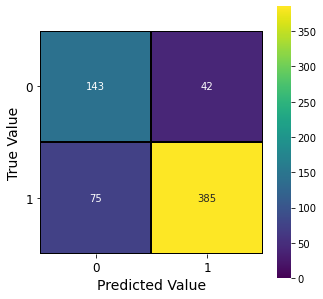

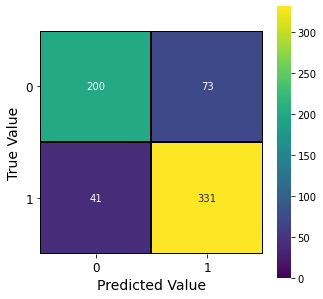

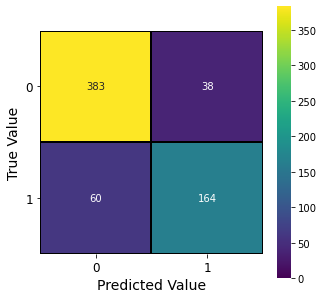

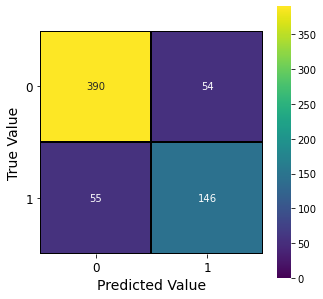

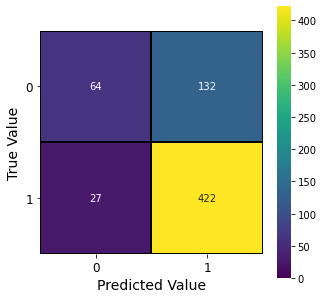

In [96]:
for mood in ["content","stress","lonely","sad","energy"]:
    y_true, y_pred = get_predictions(data_bi,mood,tuned_models["logistic_regression"])
    _ = get_cm(y_true, y_pred, plot=True)

### Defining the Confusion Matrix
* **Positive Classes**: 2 and 3
* **Negative Classes**: 0 and 1

## All the metrics
Who knew there was a fancy function for all this? In addition, we borrow some advice from the TDS crew.

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, cohen_kappa_score,log_loss

In [27]:
def get_scoring_metrics(df,model,moods=["content","stress","lonely","sad","energy"]):
    """
    Gets the various scoring metrics
    """
    res = {"mood":[],"accuracy":[],"precision":[],"recall":[],"roc_auc":[],"f1":[],"kappa":[],"log-loss":[]}
    for mood in moods:
        y_true, y_pred = get_predictions(data,mood,model)
        _, y_pred_prob = get_predictions(data,mood,model,probability=True)
        res["mood"].append(mood)
        res["accuracy"].append(accuracy_score(y_true,y_pred))
        res["precision"].append(precision_score(y_true,y_pred, average="weighted"))
        res["recall"].append(recall_score(y_true,y_pred, average="weighted"))
        res["roc_auc"].append(roc_auc_score(y_true, y_pred_prob, multi_class="ovr", average="weighted"))
        res["f1"].append(f1_score(y_true,y_pred, average="weighted"))
        res["kappa"].append(cohen_kappa_score(y_true,y_pred))
        res["log-loss"].append(log_loss(y_true,y_pred_prob))
        
    return pd.DataFrame(res)

In [97]:
get_scoring_metrics(data_bi,tuned_models["logistic_regression"])

,mood,accuracy,precision,recall,roc_auc,f1,kappa,log-loss
0,content,0.683625,0.676637,0.683625,0.815160,0.673952,0.529660,0.862665
1,stress,0.686306,0.690143,0.686306,0.844823,0.680518,0.510113,0.829339
2,lonely,0.753577,0.741793,0.753577,0.859395,0.746691,0.516319,0.670091
3,sad,0.801272,0.767616,0.801272,0.877266,0.783389,0.555786,0.607318
4,energy,0.536508,0.565026,0.536508,0.708375,0.464900,0.254547,1.217365


In [29]:
def get_report(df,model,mood="content"):
    """
    Gets the classification report and prints it
    
    """
    y_true, y_pred = get_predictions(df,mood,model)
    print(mood)
    print(classification_report(y_true, y_pred))

In [30]:
get_report(data,tuned_models["logistic_regression"],"lonely")

lonely
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89       413
         1.0       0.65      0.54      0.59       158
         2.0       0.47      0.44      0.46        52
         3.0       0.00      0.00      0.00         6

    accuracy                           0.78       629
   macro avg       0.49      0.48      0.49       629
weighted avg       0.77      0.78      0.77       629



---

[Back to Top](#top)